# **Notebook zur Evaluation - Scan-Prozess**
***

In [50]:
from FC.FC_save_load_global_hook_dict import load_csv_to_dict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
import os
import matplotlib.cm as cm

***
## **Wiederholungsgenauigkeit**

**Dicts laden**

In [51]:
dir_path = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/6_Wiederholungsgenauigkeit/HakenmodellD/csv'

In [52]:
dicts_list = []

for testrun_folder in sorted(os.listdir(dir_path)):
    testrun_folder_path = os.path.join(dir_path, testrun_folder)

    if os.path.isdir(testrun_folder_path) and testrun_folder.isdigit():
        data = os.listdir(testrun_folder_path)
        csv_data = [f for f in data if f.endswith('.csv')]

        if len(csv_data) == 1:
            csv_path = os.path.join(testrun_folder_path, csv_data[0])
            dicts_list.append(load_csv_to_dict(csv_path))
        else:
            print(f"No CSV file in: {testrun_folder_path}")

print(f"{len(dicts_list)} Dictionaries found...")

10 Dictionaries found...


**Mittelwert der Koordinaten pro Haken berechnen**

In [53]:
def calculate_mean(dicts_list = None):
    """
    Berechnet für alle Koordnaten (Spitze und Senke) den Mittelwert X_mean, Y_mean, Z_mean für jeden Haken"
    """
    mean_xyz_tip_in_workframe = []
    mean_xyz_lowpoint_in_workframe = []

    for hook_idx in range(len(dicts_list[0])):
        # hole Haken x aus allen dicts und berechne Summe
        sum_xyz_tip = np.zeros(3)
        sum_xyz_lowpoint = np.zeros(3)
        
        dict_key = str(hook_idx + 1)
        for dict in (dicts_list):
            xyz_tip_in_workframe = dict[dict_key]['xyz_tip_in_workframe']
            xyz_lowpoint_in_workframe = dict[dict_key]['xyz_lowpoint_in_workframe']
            sum_xyz_tip += xyz_tip_in_workframe
            sum_xyz_lowpoint += xyz_lowpoint_in_workframe
        
        # Berechne Mittelwert für Haken x und hänge an Ergebnis-Liste dran
        tip_mean = sum_xyz_tip / len(dicts_list)
        lowpoint_mean = sum_xyz_lowpoint / len(dicts_list)
        mean_xyz_tip_in_workframe.append(tip_mean)
        mean_xyz_lowpoint_in_workframe.append(lowpoint_mean)

    return mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe

**Werte als Scatter plotten**

In [54]:
def plot_values(dicts_list=None, tip_mean_list=None, lowpoint_mean_list=None):
    """
    Plottet die x, y, z-Werte für jeden Haken-Tip und -Lowpoint in einem 2x3 Plot.
    Links: Tip-Koordinaten (x, y, z)
    Rechts: Lowpoint-Koordinaten (x, y, z)
    """
    num_hooks = len(dicts_list[0])
    num_samples = len(dicts_list)

    # Datenstruktur initialisieren
    tips = np.zeros((num_hooks, num_samples, 3))       # shape: (hooks, samples, xyz)
    lowpoints = np.zeros((num_hooks, num_samples, 3))  # shape: (hooks, samples, xyz)

    for hook_idx in range(num_hooks):
        dict_key = str(hook_idx + 1)
        for sample_idx, d in enumerate(dicts_list):
            tips[hook_idx, sample_idx] = d[dict_key]['xyz_tip_in_workframe']
            lowpoints[hook_idx, sample_idx] = d[dict_key]['xyz_lowpoint_in_workframe']

    fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
    fig.suptitle('Wiederholungsgenauigkeit bei gleichem Hakenmodell bzw. Setup', fontsize=16)
    coord_labels = ['x', 'y', 'z']

    for i in range(3):  # Für x, y, z
        # Tip-Daten plotten (linke Spalte)
        # axs[i, 0].plot(range(1, num_hooks + 1), tips[:, :, i].mean(axis=1), label='Mean', marker='o')
        axs[i, 0].scatter(np.repeat(np.arange(1, num_hooks + 1), num_samples), 
                         tips[:, :, i].flatten(), alpha=0.6, label='Koordinate')
        if tip_mean_list:
            axs[i, 0].plot(range(1, num_hooks + 1), [tip_mean_list[hook_idx][i] for hook_idx in range(num_hooks)], 
                           label='Mittelwert', linestyle='--', color='red')
        axs[i, 0].set_ylabel(f'Spitze {coord_labels[i]}')
        axs[i, 0].legend()
        axs[i, 0].grid()

        # Lowpoint-Daten plotten (rechte Spalte)
        # axs[i, 1].plot(range(1, num_hooks + 1), lowpoints[:, :, i].mean(axis=1), label='Mean', marker='o')
        axs[i, 1].scatter(np.repeat(np.arange(1, num_hooks + 1), num_samples), 
                         lowpoints[:, :, i].flatten(), alpha=0.6, label='Koordinate')
        if lowpoint_mean_list:
            axs[i, 1].plot(range(1, num_hooks + 1), [lowpoint_mean_list[hook_idx][i] for hook_idx in range(num_hooks)], 
                           label='Mittelwert', linestyle='--', color='red')
        axs[i, 1].set_ylabel(f'Senke {coord_labels[i]}')
        axs[i, 1].legend()
        axs[i, 1].grid()

    for ax in axs[2]:
        ax.set_xlabel('Haken-Instanz')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

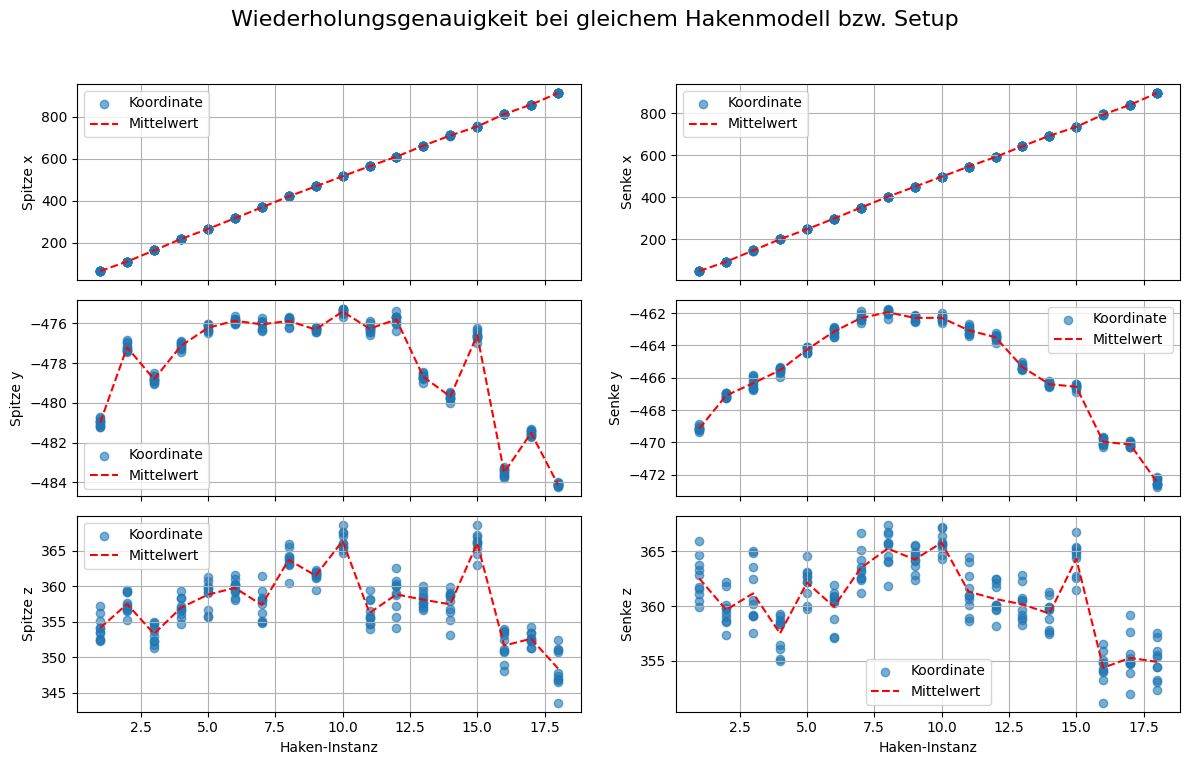

In [55]:
mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe = calculate_mean(dicts_list)
plot_values(dicts_list = dicts_list, tip_mean_list = mean_xyz_tip_in_workframe, lowpoint_mean_list = mean_xyz_lowpoint_in_workframe)

### **Wahrscheinlichkeits-Verteilung**

**Berechnung der Treffer-Wahrscheinlichkeit - Spitze wird als unendlich kleiner Punkt angenommen**

In [56]:
def probability_within_slot_gmm(dicts_list, hook_num=1, slot_length=12, slot_width=5, slot_depth=10, n_components=2):
    coords = {'x': [], 'y': [], 'z': []}
    for d in dicts_list:
        pt = d[str(hook_num)]['xyz_tip_in_workframe']
        coords['x'].append(pt[0])
        coords['y'].append(pt[1])
        coords['z'].append(pt[2])

    slot_half = {
        'x': slot_width / 2,
        'y': slot_depth / 2,
        'z': slot_length / 2
    }

    total_prob = 1.0
    for axis in ['x', 'y', 'z']:
        data = np.array(coords[axis]).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)

        weights = gmm.weights_
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_.flatten())
        center = np.mean(data)
        lower = center - slot_half[axis]
        upper = center + slot_half[axis]

        # Komponentensumme der Wahrscheinlichkeit
        prob_axis = 0
        for w, mu, sigma in zip(weights, means, stds):
            cdf_upper = norm.cdf((upper - mu) / sigma)
            cdf_lower = norm.cdf((lower - mu) / sigma)
            prob_axis += w * (cdf_upper - cdf_lower)

        print(f"{axis}-Achse: μ-Komponenten = {np.round(means, 2)}, σ-Komponenten = {np.round(stds, 2)}, Gewichte = {np.round(weights, 2)}")
        print(f"Zielbereich: [{lower:.2f}, {upper:.2f}] → Wahrscheinlichkeit = {prob_axis*100:.2f} %\n")
        total_prob *= prob_axis

    print(f"Gesamte Wahrscheinlichkeit für das Treffen der Hakenspitze (GMM): {total_prob*100:.2f} %\n")
    return total_prob

In [57]:
prob = probability_within_slot_gmm(dicts_list, hook_num=8, slot_length=13, slot_width=7, slot_depth=10, n_components=2)

x-Achse: μ-Komponenten = [420.47 420.13], σ-Komponenten = [0.06 0.04], Gewichte = [0.6 0.4]
Zielbereich: [416.83, 423.83] → Wahrscheinlichkeit = 100.00 %

y-Achse: μ-Komponenten = [-475.8  -476.21], σ-Komponenten = [0.07 0.01], Gewichte = [0.8 0.2]
Zielbereich: [-480.88, -470.88] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.12 360.44], σ-Komponenten = [0.96 0.  ], Gewichte = [0.9 0.1]
Zielbereich: [357.25, 370.25] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit für das Treffen der Hakenspitze (GMM): 100.00 %



**Berechnung der Treffer-Wahrscheinlichkeit unter Berücksichtigung der Spitzendicke und der Lochgröße**

In [58]:
def probability_within_slot_gmm(dicts_list, hook_num=1,
                                 slot_length=13, slot_width=7, slot_depth=10,
                                 tip_width=2, tip_to_lp_dist=9, tip_length=5,
                                 n_components=2, plot_y=False):
    import numpy as np
    from sklearn.mixture import GaussianMixture
    from scipy.stats import norm

    # Achsen festlegen basierend auf plot_y
    axes = ['x', 'z'] if not plot_y else ['x', 'y', 'z']

    # Koordinaten sammeln
    coords = {axis: [] for axis in axes}
    for d in dicts_list:
        pt = d[str(hook_num)]['xyz_tip_in_workframe']
        if 'x' in axes: coords['x'].append(pt[0])
        if 'y' in axes: coords['y'].append(pt[1])
        if 'z' in axes: coords['z'].append(pt[2])

    # Sicherheitsabstände berechnen
    slot_half = {
        'x': (slot_width / 2) - (tip_width / 2),
        'y': (slot_depth / 2) - (tip_to_lp_dist / 2),
        'z': (slot_length / 2) - (tip_length / 2)
    }

    # Gültigkeit prüfen
    for axis in axes:
        if slot_half[axis] <= 0:
            raise ValueError(f"Spitze ist größer als das Slot in {axis}-Richtung!")

    total_prob = 1.0
    for axis in axes:
        data = np.array(coords[axis]).reshape(-1, 1)
        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)

        weights = gmm.weights_
        means = gmm.means_.flatten()
        stds = np.sqrt(gmm.covariances_.flatten())
        center = np.mean(data)
        lower = center - slot_half[axis]
        upper = center + slot_half[axis]

        prob_axis = 0
        for w, mu, sigma in zip(weights, means, stds):
            cdf_upper = norm.cdf((upper - mu) / sigma)
            cdf_lower = norm.cdf((lower - mu) / sigma)
            prob_axis += w * (cdf_upper - cdf_lower)

        print(f"{axis}-Achse: μ-Komponenten = {np.round(means, 2)}, σ-Komponenten = {np.round(stds, 2)}, Gewichte = {np.round(weights, 2)}")
        print(f"Zielbereich (angepasst): [{lower:.2f}, {upper:.2f}] → Wahrscheinlichkeit = {prob_axis*100:.2f} %\n")
        total_prob *= prob_axis

    print(f"\033[1mGesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): {total_prob*100:.2f} %\n\033[0m")
    return total_prob

In [59]:
def plot_xyz_distribution(dicts_list, hook_num=1, n_components=2,
                          slot_length=12, slot_width=5, slot_depth=10,
                          tip_width=2, tip_to_lp_dist=2, tip_length=1,
                          plot_y=False):
    """
    Plottet die Verteilungen der x-, y- und z-Koordinaten eines bestimmten Hakens
    inkl. Histogramm, Normalverteilung, GMM-Komponenten und Trefferbereich.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    from sklearn.mixture import GaussianMixture

    x_values, y_values, z_values = [], [], []

    for scan_dict in dicts_list:
        coords = scan_dict[str(hook_num)]['xyz_tip_in_workframe']
        x_values.append(coords[0])
        y_values.append(coords[1])
        z_values.append(coords[2])

    axis_labels = ['x', 'y', 'z']
    all_coords = [x_values, y_values, z_values]

    # Optional: y-Koordinate entfernen, wenn nicht gewünscht
    if not plot_y:
        axis_labels.pop(1)
        all_coords.pop(1)

    slot_dims = {'x': slot_width, 'y': slot_depth, 'z': slot_length}
    tip_dims = {'x': tip_width, 'y': tip_to_lp_dist, 'z': tip_length}
    mu_std_results = {}

    fig, axs = plt.subplots(1, len(axis_labels), figsize=(7 * len(axis_labels), 4))

    if len(axis_labels) == 1:
        axs = [axs]  # sicherstellen, dass axs iterierbar ist

    for i, (coord, label) in enumerate(zip(all_coords, axis_labels)):
        data = np.array(coord).reshape(-1, 1)
        mu, std = norm.fit(data)

        gmm = GaussianMixture(n_components=n_components, random_state=0)
        gmm.fit(data)
        weights = gmm.weights_
        means = gmm.means_.flatten()
        covs = gmm.covariances_.flatten()
        stds = np.sqrt(covs)

        x_plot = np.linspace(data.min(), data.max(), 1000)
        norm_pdf = norm.pdf(x_plot, mu, std)

        axs[i].hist(data, bins='sturges', density=True, alpha=0.6,
                    color='gray', edgecolor='black', label='Messwerte')
        axs[i].plot(x_plot, norm_pdf, 'r', linewidth=2, label='Normalverteilung')

        gmm_total = np.zeros_like(x_plot)
        for j in range(n_components):
            comp_pdf = weights[j] * norm.pdf(x_plot, means[j], stds[j])
            gmm_total += comp_pdf
            axs[i].plot(x_plot, comp_pdf, '--', linewidth=1.2, label=f'GMM Komp. {j+1}')

        axs[i].plot(x_plot, gmm_total, 'b', linewidth=2, label='GMM Gesamt')

        center = np.mean(data)
        half_slot = (slot_dims[label] / 2) - (tip_dims[label] / 2)
        lower = center - half_slot
        upper = center + half_slot
        axs[i].axvspan(lower, upper, color='lightgreen', alpha=0.3, label='valider Bereich')

        axs[i].set_title(f"Verteilung der {label}-Koordinate (Haken {hook_num})")
        axs[i].set_xlabel(f"{label}-Wert")
        axs[i].set_ylabel("Dichte")
        axs[i].legend()

        mu_std_results[label] = (mu, std)

    plt.tight_layout()
    plt.show()

    return mu_std_results

In [60]:
def plot_prob_and_hist(hook_num=1, dicts_list=None, plot_y=False):    
    slot_length = 12        # Die lange Seite des Langlochs
    slot_width = 7        # kurze Seite des Langlochs
    slot_depth = 10         # Weg in Hakenrichtung, der als valide gewertet wird

    tip_length = 5          # Spitze Dicke nach hinten (z-Richtung)
    tip_width = 2         # Spitze Breite (Dicke des Metalls)
    tip_to_lp_dist = 0    # Weg von Spitze zu Senke

    n_components = 2        # Wie viele Normalverteilungen liegen vor

    print("\033[1m---------------------------------------------------------------------------------------------------------\033[0m")
    print("\033[1mDaten für Haken \033[0m", hook_num)
    mu_std_results = plot_xyz_distribution(
        dicts_list,
        hook_num=hook_num,
        slot_length=slot_length, slot_width=slot_width, slot_depth=slot_depth,
        tip_length=tip_length, tip_width=tip_width, tip_to_lp_dist=tip_to_lp_dist,
        n_components=n_components,
        plot_y=plot_y
    )

    probs = probability_within_slot_gmm(
        dicts_list, 
        hook_num=hook_num,
        slot_length=slot_length, slot_width=slot_width, slot_depth=slot_depth,
        tip_width=tip_width, tip_to_lp_dist=tip_to_lp_dist, tip_length=tip_length,
        n_components=n_components,
        plot_y=plot_y
    )

    return mu_std_results, probs

---------------------------------------------------------------------------------------------------------
Daten für Haken  1


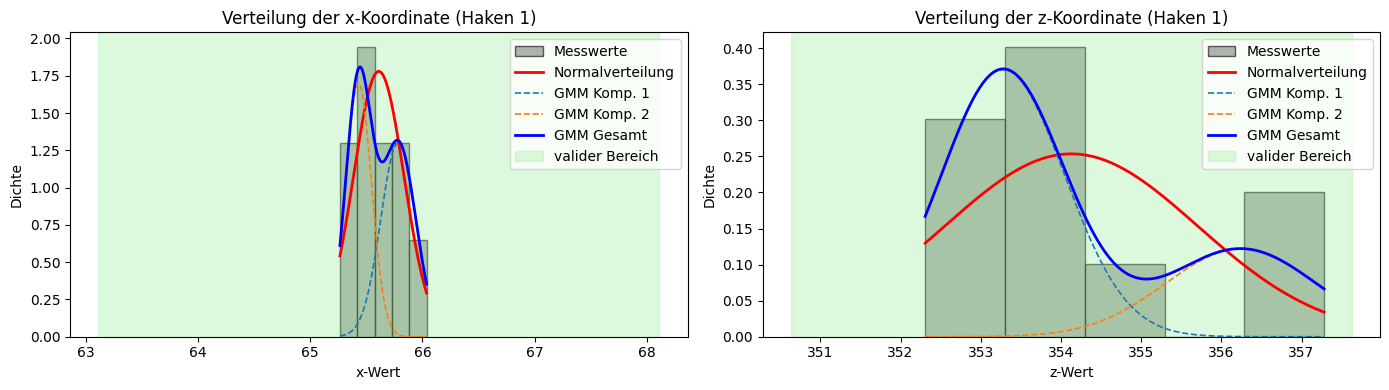

x-Achse: μ-Komponenten = [65.78 65.43], σ-Komponenten = [0.16 0.12], Gewichte = [0.51 0.49]
Zielbereich (angepasst): [63.11, 68.11] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [353.28 356.24], σ-Komponenten = [0.77 0.94], Gewichte = [0.71 0.29]
Zielbereich (angepasst): [350.63, 357.63] → Wahrscheinlichkeit = 97.96 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 97.96 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  2


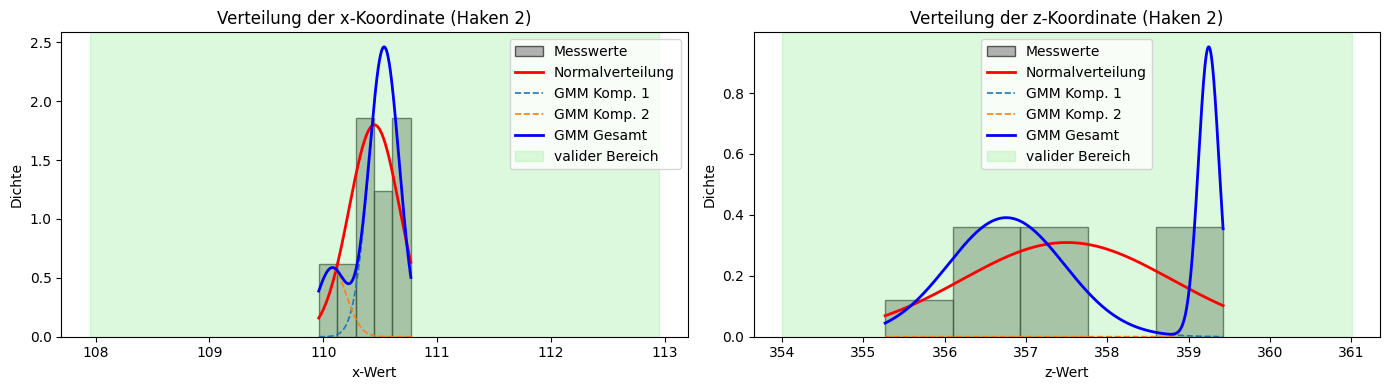

x-Achse: μ-Komponenten = [110.53 110.08], σ-Komponenten = [0.13 0.13], Gewichte = [0.81 0.19]
Zielbereich (angepasst): [107.95, 112.95] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [356.76 359.25], σ-Komponenten = [0.71 0.13], Gewichte = [0.7 0.3]
Zielbereich (angepasst): [354.00, 361.00] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  3


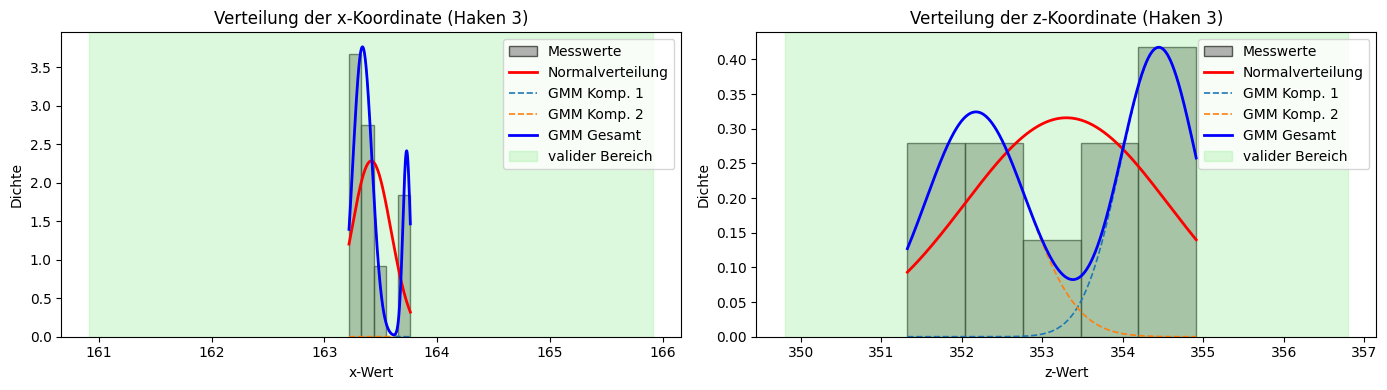

x-Achse: μ-Komponenten = [163.34 163.73], σ-Komponenten = [0.08 0.03], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [160.92, 165.92] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [354.45 352.18], σ-Komponenten = [0.47 0.62], Gewichte = [0.49 0.51]
Zielbereich (angepasst): [349.80, 356.80] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  4


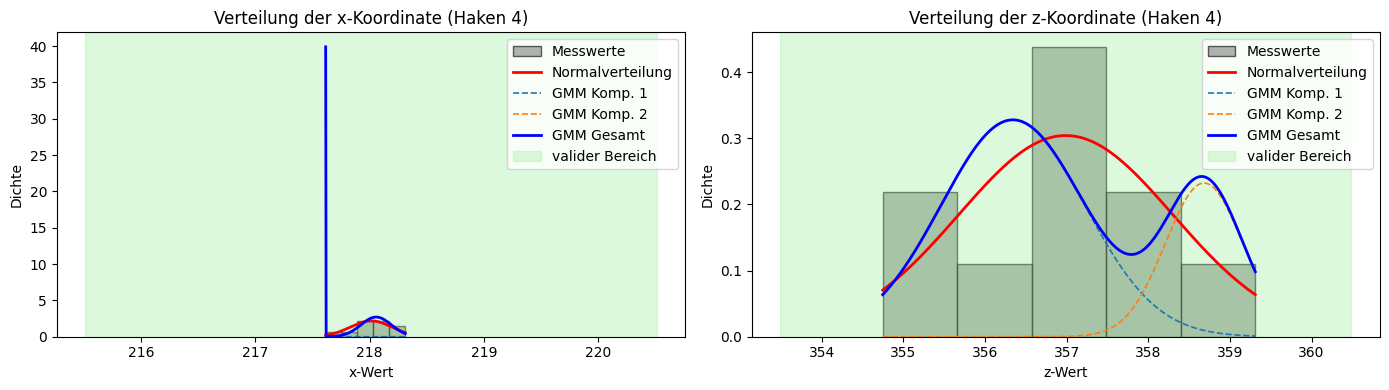

x-Achse: μ-Komponenten = [217.62 218.06], σ-Komponenten = [0.   0.13], Gewichte = [0.1 0.9]
Zielbereich (angepasst): [215.51, 220.51] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [356.34 358.68], σ-Komponenten = [0.88 0.48], Gewichte = [0.72 0.28]
Zielbereich (angepasst): [353.49, 360.49] → Wahrscheinlichkeit = 99.95 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 99.95 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  5


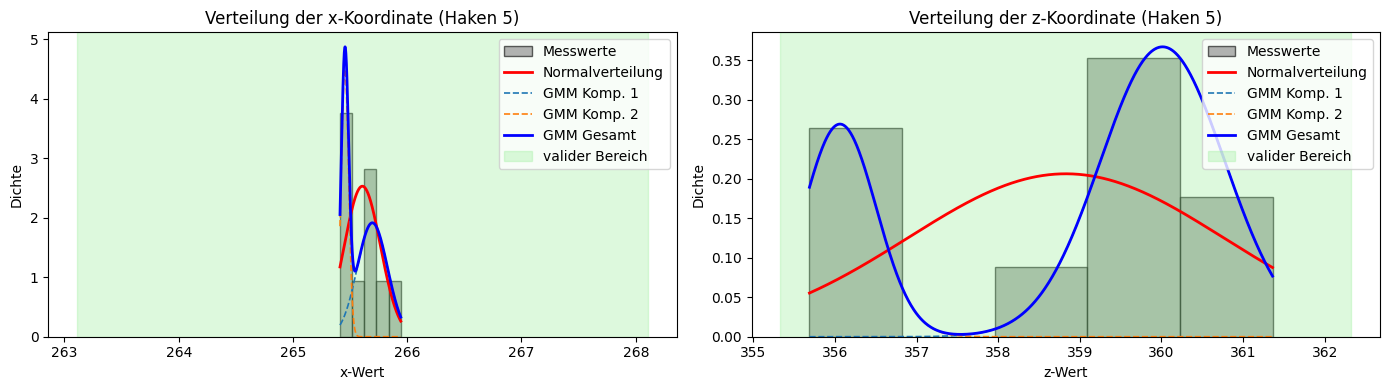

x-Achse: μ-Komponenten = [265.69 265.45], σ-Komponenten = [0.13 0.03], Gewichte = [0.64 0.36]
Zielbereich (angepasst): [263.11, 268.11] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [360.01 356.06], σ-Komponenten = [0.76 0.44], Gewichte = [0.7 0.3]
Zielbereich (angepasst): [355.33, 362.33] → Wahrscheinlichkeit = 98.42 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 98.42 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  6


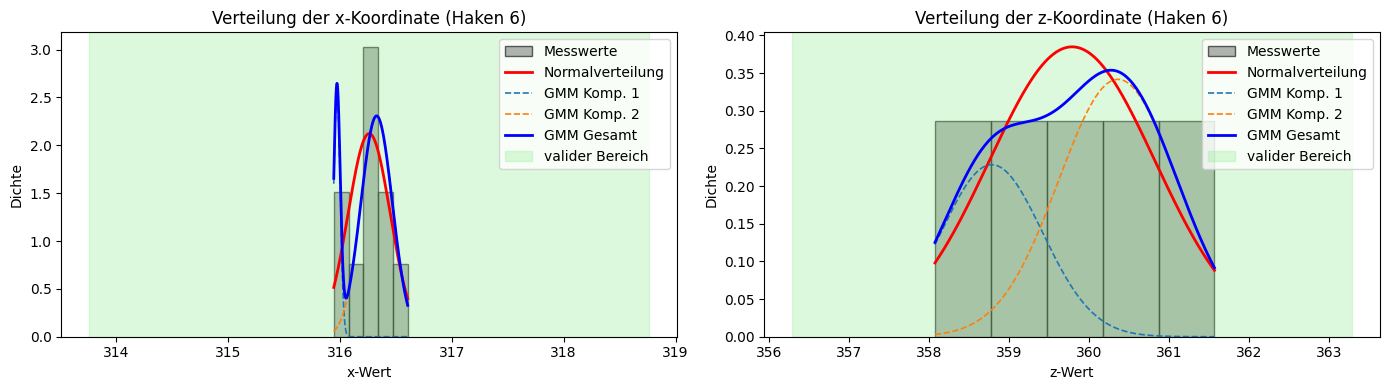

x-Achse: μ-Komponenten = [315.98 316.33], σ-Komponenten = [0.03 0.14], Gewichte = [0.19 0.81]
Zielbereich (angepasst): [313.76, 318.76] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.79 360.36], σ-Komponenten = [0.64 0.74], Gewichte = [0.36 0.64]
Zielbereich (angepasst): [356.29, 363.29] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  7


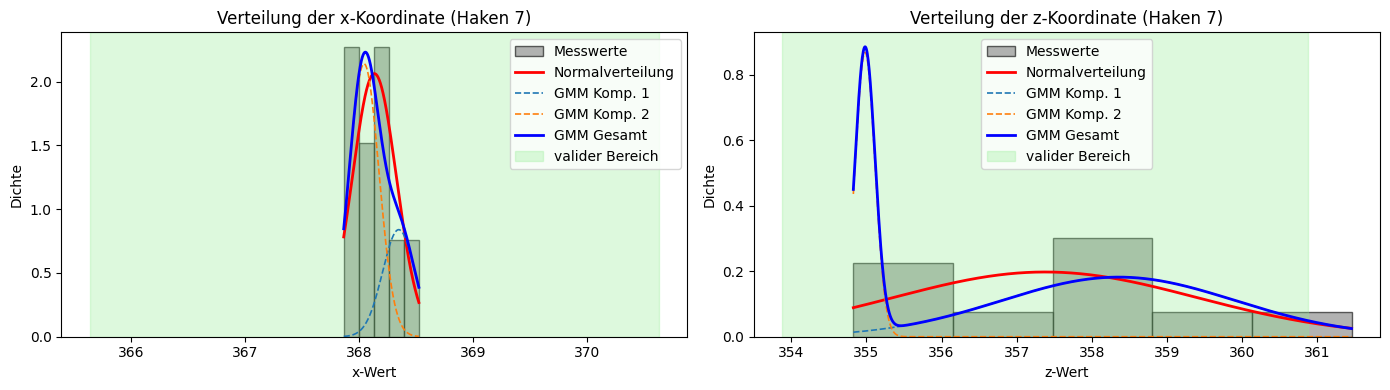

x-Achse: μ-Komponenten = [368.35 368.05], σ-Komponenten = [0.14 0.13], Gewichte = [0.3 0.7]
Zielbereich (angepasst): [365.64, 370.64] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.36 354.98], σ-Komponenten = [1.56 0.13], Gewichte = [0.71 0.29]
Zielbereich (angepasst): [353.88, 360.88] → Wahrscheinlichkeit = 96.13 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 96.13 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  8


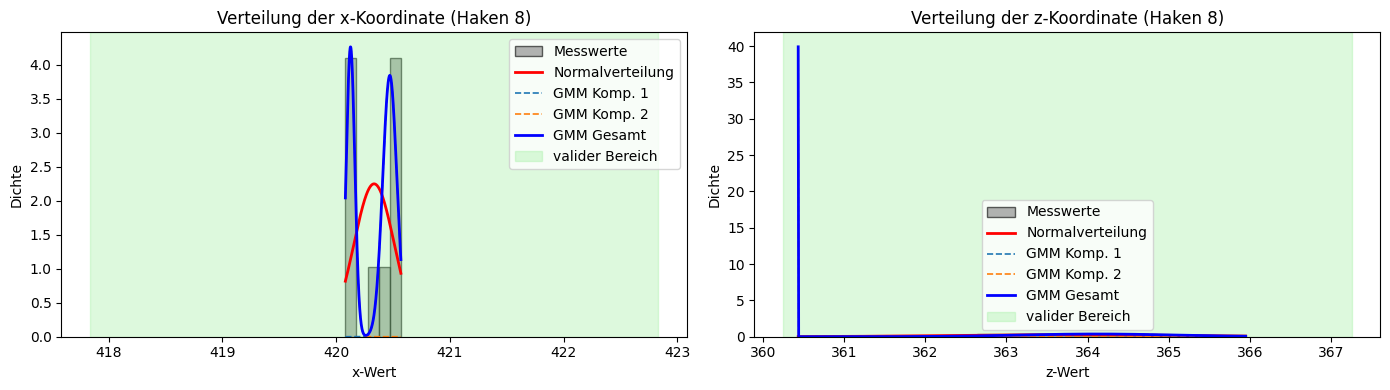

x-Achse: μ-Komponenten = [420.47 420.13], σ-Komponenten = [0.06 0.04], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [417.83, 422.83] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [364.12 360.44], σ-Komponenten = [0.96 0.  ], Gewichte = [0.9 0.1]
Zielbereich (angepasst): [360.25, 367.25] → Wahrscheinlichkeit = 99.95 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 99.95 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  9


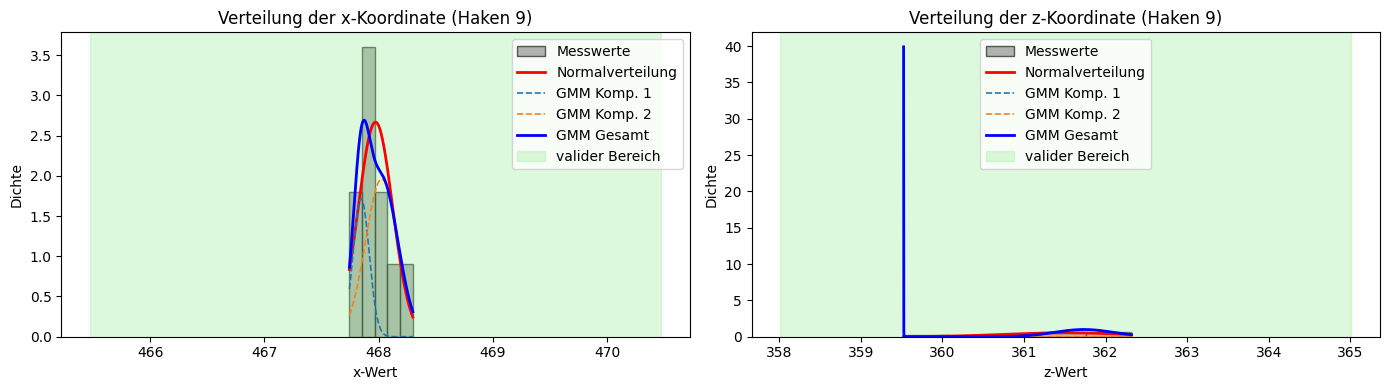

x-Achse: μ-Komponenten = [467.85 468.03], σ-Komponenten = [0.07 0.14], Gewichte = [0.3 0.7]
Zielbereich (angepasst): [465.47, 470.47] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [361.73 359.53], σ-Komponenten = [0.36 0.  ], Gewichte = [0.9 0.1]
Zielbereich (angepasst): [358.01, 365.01] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  10


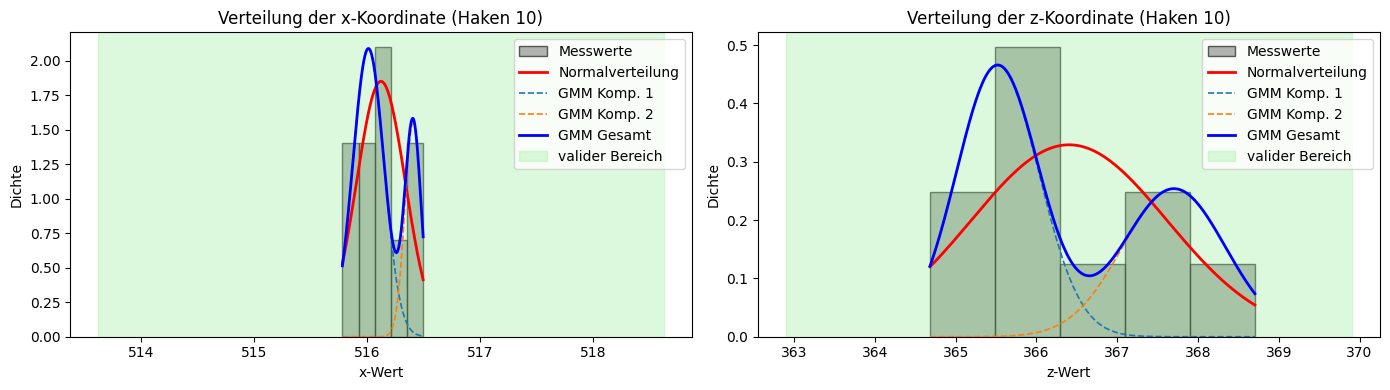

x-Achse: μ-Komponenten = [516.01 516.41], σ-Komponenten = [0.14 0.07], Gewichte = [0.72 0.28]
Zielbereich (angepasst): [513.62, 518.62] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [365.52 367.7 ], σ-Komponenten = [0.51 0.64], Gewichte = [0.59 0.41]
Zielbereich (angepasst): [362.90, 369.90] → Wahrscheinlichkeit = 99.99 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 99.99 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  11


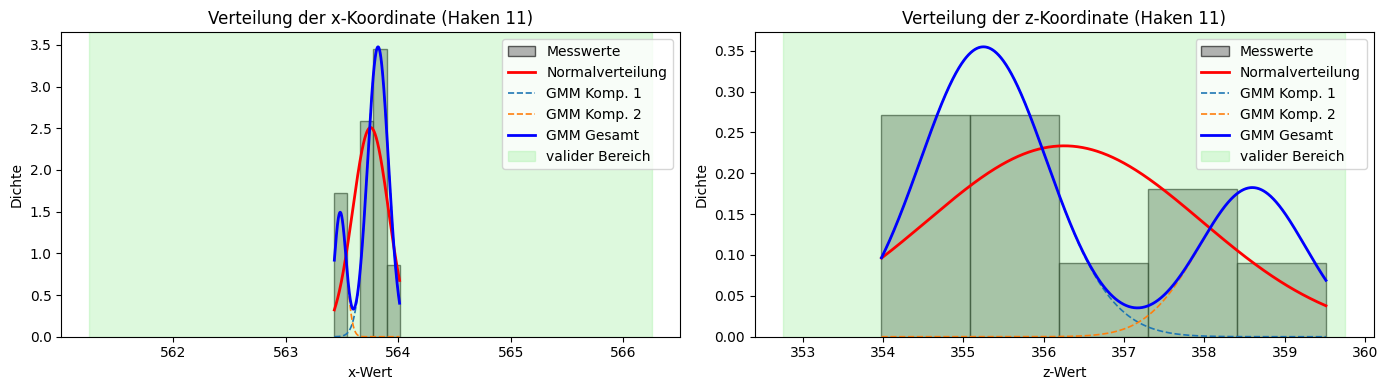

x-Achse: μ-Komponenten = [563.82 563.48], σ-Komponenten = [0.09 0.05], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [561.25, 566.25] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [355.25 358.6 ], σ-Komponenten = [0.79 0.66], Gewichte = [0.7 0.3]
Zielbereich (angepasst): [352.75, 359.75] → Wahrscheinlichkeit = 98.78 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 98.78 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  12


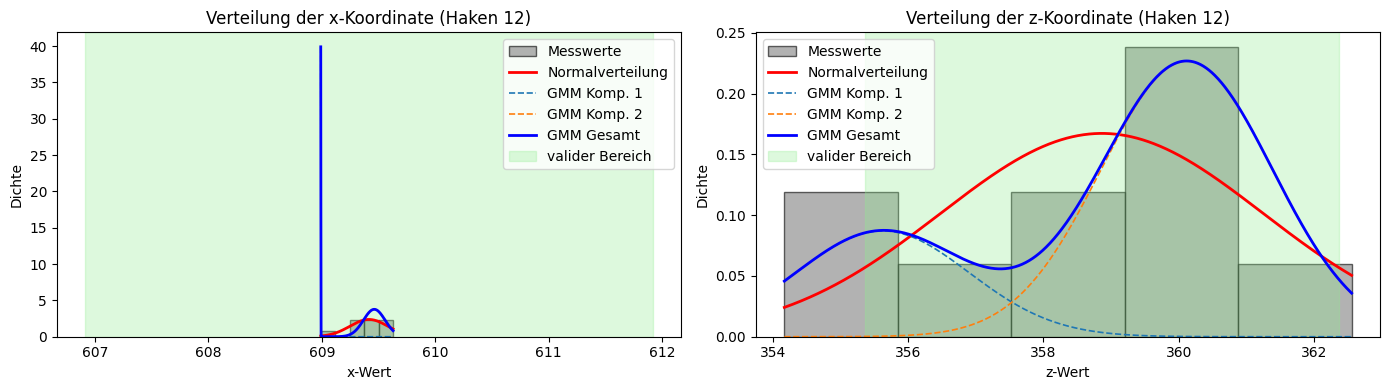

x-Achse: μ-Komponenten = [608.99 609.46], σ-Komponenten = [0.  0.1], Gewichte = [0.1 0.9]
Zielbereich (angepasst): [606.92, 611.92] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [355.62 360.12], σ-Komponenten = [1.28 1.27], Gewichte = [0.28 0.72]
Zielbereich (angepasst): [355.36, 362.36] → Wahrscheinlichkeit = 85.48 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 85.48 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  13


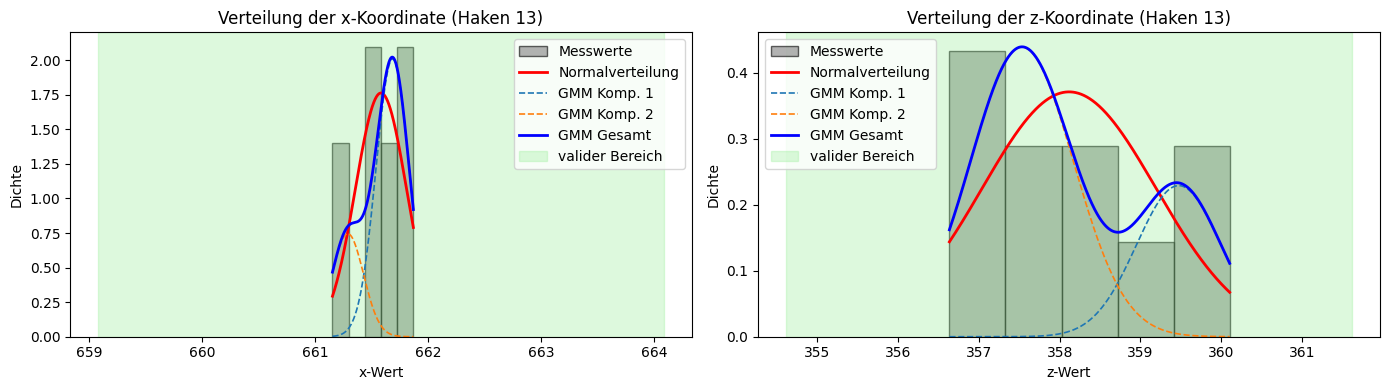

x-Achse: μ-Komponenten = [661.69 661.29], σ-Komponenten = [0.15 0.14], Gewichte = [0.74 0.26]
Zielbereich (angepasst): [659.08, 664.08] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [359.47 357.53], σ-Komponenten = [0.52 0.64], Gewichte = [0.3 0.7]
Zielbereich (angepasst): [354.62, 361.62] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  14


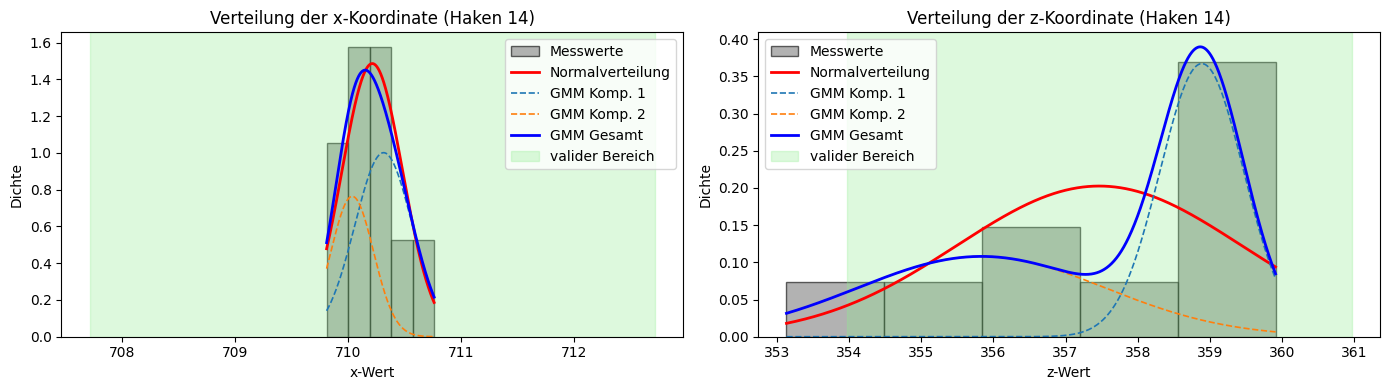

x-Achse: μ-Komponenten = [710.32 710.04], σ-Komponenten = [0.25 0.19], Gewichte = [0.64 0.36]
Zielbereich (angepasst): [707.72, 712.72] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.89 355.83], σ-Komponenten = [0.58 1.72], Gewichte = [0.53 0.47]
Zielbereich (angepasst): [353.97, 360.97] → Wahrscheinlichkeit = 93.46 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 93.46 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  15


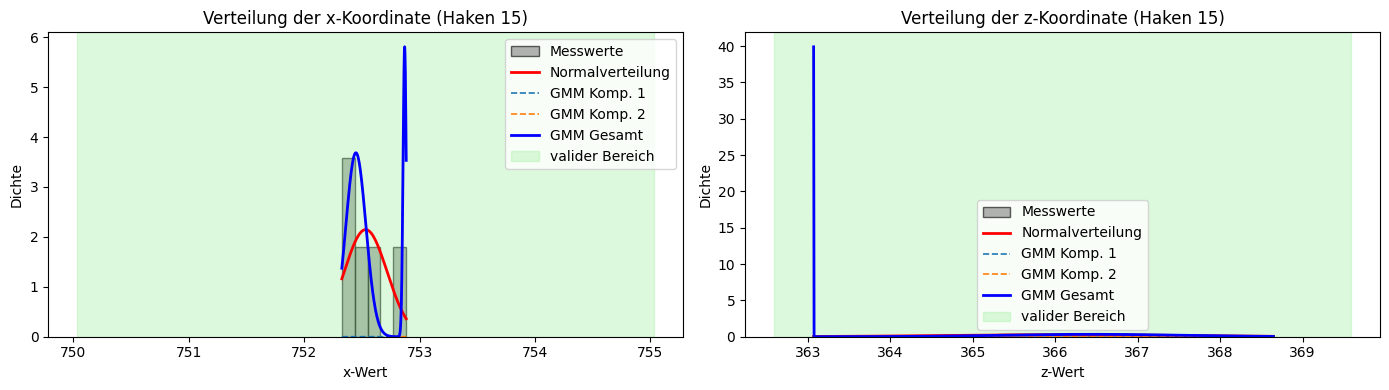

x-Achse: μ-Komponenten = [752.87 752.45], σ-Komponenten = [0.01 0.09], Gewichte = [0.2 0.8]
Zielbereich (angepasst): [750.03, 755.03] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [366.42 363.07], σ-Komponenten = [1.08 0.  ], Gewichte = [0.9 0.1]
Zielbereich (angepasst): [362.59, 369.59] → Wahrscheinlichkeit = 99.83 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 99.83 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  16


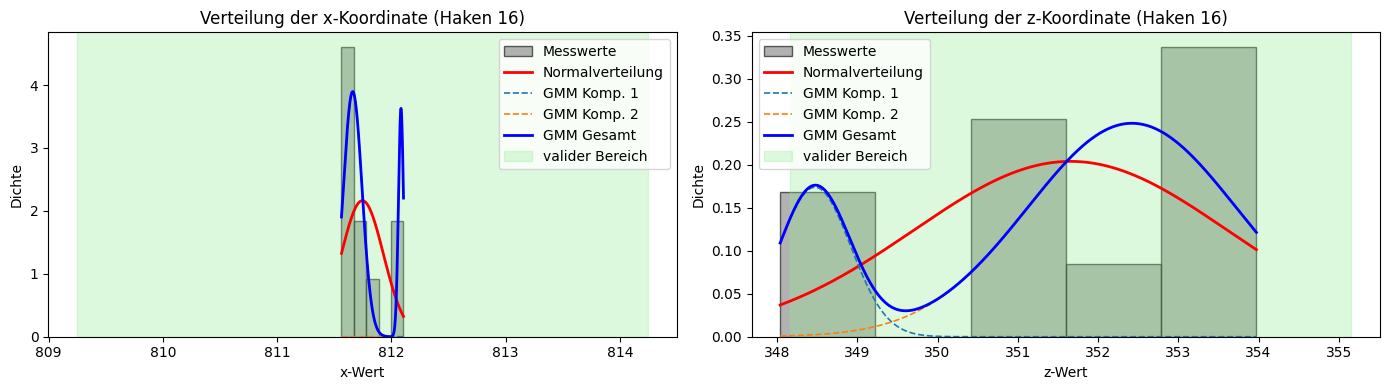

x-Achse: μ-Komponenten = [811.66 812.08], σ-Komponenten = [0.08 0.02], Gewichte = [0.8 0.2]
Zielbereich (angepasst): [809.25, 814.25] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [348.47 352.42], σ-Komponenten = [0.44 1.3 ], Gewichte = [0.19 0.81]
Zielbereich (angepasst): [348.16, 355.16] → Wahrscheinlichkeit = 93.92 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 93.92 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  17


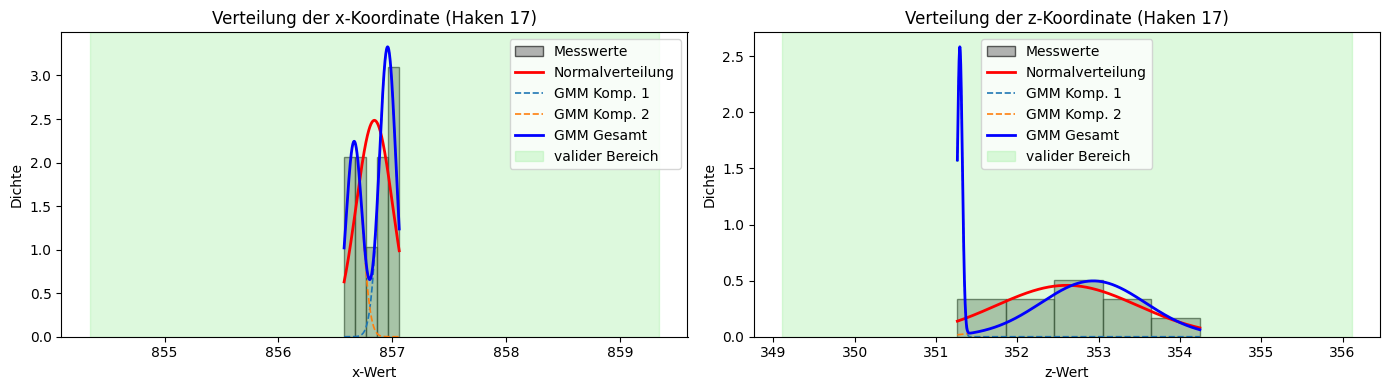

x-Achse: μ-Komponenten = [856.96 856.67], σ-Komponenten = [0.07 0.07], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [854.34, 859.34] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [351.29 352.93], σ-Komponenten = [0.03 0.64], Gewichte = [0.2 0.8]
Zielbereich (angepasst): [349.11, 356.11] → Wahrscheinlichkeit = 100.00 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 100.00 %

---------------------------------------------------------------------------------------------------------
Daten für Haken  18


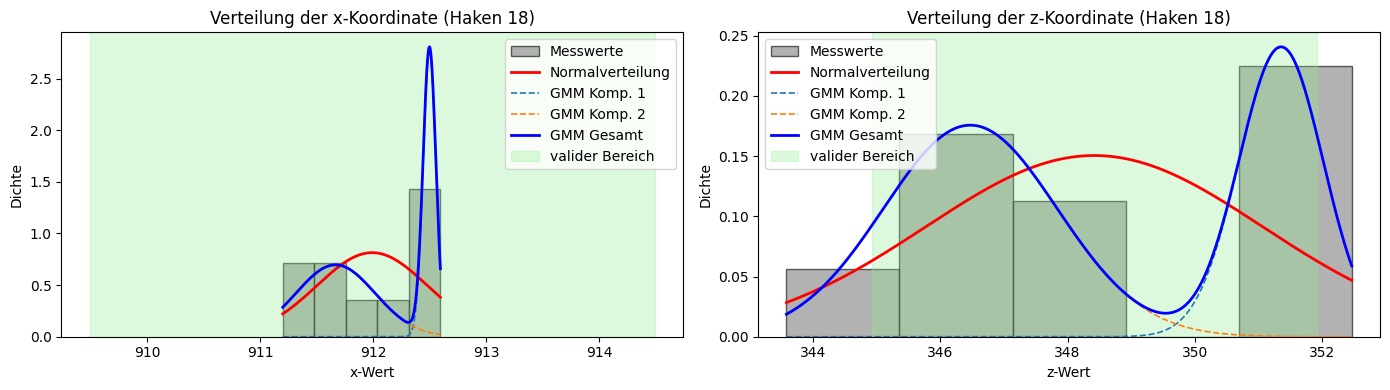

x-Achse: μ-Komponenten = [912.5  911.67], σ-Komponenten = [0.06 0.35], Gewichte = [0.39 0.61]
Zielbereich (angepasst): [909.49, 914.49] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [351.36 346.47], σ-Komponenten = [0.66 1.37], Gewichte = [0.4 0.6]
Zielbereich (angepasst): [344.92, 351.92] → Wahrscheinlichkeit = 84.38 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 84.38 %

Durchschnittliche Verteilungs-Mittelwerte - XYZ:  488.33385056212603 None 357.72541695223515
Durchschnittliche Standardabweichungen - XYZ:  0.2070909830347583 None 1.548525918929271


In [61]:
mu_x_mean = 0
mu_y_mean = 0
mu_z_mean = 0

std_x_mean = 0
std_y_mean = 0
std_z_mean = 0

plot_y=False

for hook_num in range(len(dicts_list[0])):
    mu_std_results, probs = plot_prob_and_hist(hook_num+1, dicts_list, plot_y=plot_y)
    
    mu_x_mean += mu_std_results['x'][0]
    if plot_y:
        mu_y_mean += mu_std_results['y'][0]
    mu_z_mean += mu_std_results['z'][0]
    
    std_x_mean += mu_std_results['x'][1]
    if plot_y:
        std_y_mean += mu_std_results['y'][1]
    std_z_mean += mu_std_results['z'][1]

mu_x_mean /= len(dicts_list[0])
if plot_y:
    mu_y_mean /= len(dicts_list[0])
    std_y_mean /= len(dicts_list[0])
else:
    mu_y_mean = None
    std_y_mean = None
mu_z_mean /= len(dicts_list[0])

std_x_mean /= len(dicts_list[0])
std_z_mean /= len(dicts_list[0])

print("Durchschnittliche Verteilungs-Mittelwerte - XYZ: ", mu_x_mean, mu_y_mean, mu_z_mean)
print("Durchschnittliche Standardabweichungen - XYZ: ", std_x_mean, std_y_mean, std_z_mean)

***
## **Geschwindigkeitsvariationen**

**Dicts laden**

In [66]:
dir_path = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/2_Geschwindigkeit'

In [67]:
dicts_list = []

for testrun_folder in sorted(os.listdir(dir_path)):
    testrun_folder_path = os.path.join(dir_path, testrun_folder)

    if os.path.isdir(testrun_folder_path) and testrun_folder.isdigit():
        data = os.listdir(testrun_folder_path)
        csv_data = [f for f in data if f.endswith('.csv')]

        if len(csv_data) == 1:
            csv_path = os.path.join(testrun_folder_path, csv_data[0])
            dicts_list.append(load_csv_to_dict(csv_path))
        else:
            print(f"No CSV file in: {testrun_folder_path}")

print(f"{len(dicts_list)} Dictionaries found...")

7 Dictionaries found...


**Plot erstellen für Koordinaten**

In [68]:
def plot_speed_values(dicts_list=None, speed_values=None):
    """
    Plottet die x, y, z-Werte für jeden Haken-Tip und -Lowpoint in einem 2x3 Plot.
    Links: Tip-Koordinaten (x, y, z)
    Rechts: Lowpoint-Koordinaten (x, y, z)
    Jeder Punkt wird farblich markiert je nach Ursprung aus dicts_list.
    Die Legende zeigt den Geschwindigkeitswert aus speed_values.
    """
    if dicts_list is None or speed_values is None:
        raise ValueError("dicts_list und speed_values dürfen nicht None sein.")

    if len(dicts_list) != len(speed_values):
        raise ValueError("dicts_list und speed_values müssen gleich lang sein.")

    num_hooks = len(dicts_list[0])
    num_samples = len(dicts_list)

    tips = np.zeros((num_hooks, num_samples, 3))
    lowpoints = np.zeros((num_hooks, num_samples, 3))

    for hook_idx in range(num_hooks):
        dict_key = str(hook_idx + 1)
        for sample_idx, d in enumerate(dicts_list):
            tips[hook_idx, sample_idx] = d[dict_key]['xyz_tip_in_workframe']
            lowpoints[hook_idx, sample_idx] = d[dict_key]['xyz_lowpoint_in_workframe']

    cmap = cm.get_cmap('viridis', num_samples)
    colors = [cmap(i) for i in range(num_samples)]

    fig, axs = plt.subplots(3, 2, figsize=(12, 8))
    fig.suptitle('Koordinaten bei Variation der translatorischen Geschwindigkeit', fontsize=16)
    coord_labels = ['x', 'y', 'z']

    legend_lines = []
    legend_labels = []

    for i in range(3):
        for sample_idx in range(num_samples):
            speed = speed_values[sample_idx]

            # Plot Tip
            line1, = axs[i, 0].plot(
                np.arange(1, num_hooks + 1),
                tips[:, sample_idx, i],
                'o-', color=colors[sample_idx], alpha=0.6
            )

            # Plot Lowpoint
            axs[i, 1].plot(
                np.arange(1, num_hooks + 1),
                lowpoints[:, sample_idx, i],
                'o-', color=colors[sample_idx], alpha=0.6
            )

            if i == 0:
                legend_lines.append(line1)
                legend_labels.append(f'v = {speed}')

        axs[i, 0].set_ylabel(f'Spitze {coord_labels[i]}')
        axs[i, 1].set_ylabel(f'Senke {coord_labels[i]}')
        axs[i, 0].grid()
        axs[i, 1].grid()
        axs[i, 0].set_xlabel('Haken-Instanz')
        axs[i, 1].set_xlabel('Haken-Instanz')

    axs[0, 0].set_title('Spitze')
    axs[0, 1].set_title('Senke')

    # Kompaktere, rechts platzierte Legende
    fig.legend(
        legend_lines, legend_labels,
        loc='center left',
        bbox_to_anchor=(0.97, 0.5),
        title='Geschwindigkeit',
        labelspacing=0.3,  # Weniger Abstand zwischen Labels
        handlelength=2.0,  # Kürzere Linien
        borderaxespad=0.5,
        fontsize='small'
    )

    plt.tight_layout(rect=[0, 0.03, 0.92, 0.95])  # Mehr Platz für Plot, weniger für Legende
    plt.show()

/tmp/ipykernel_4827/3144174758.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', num_samples)


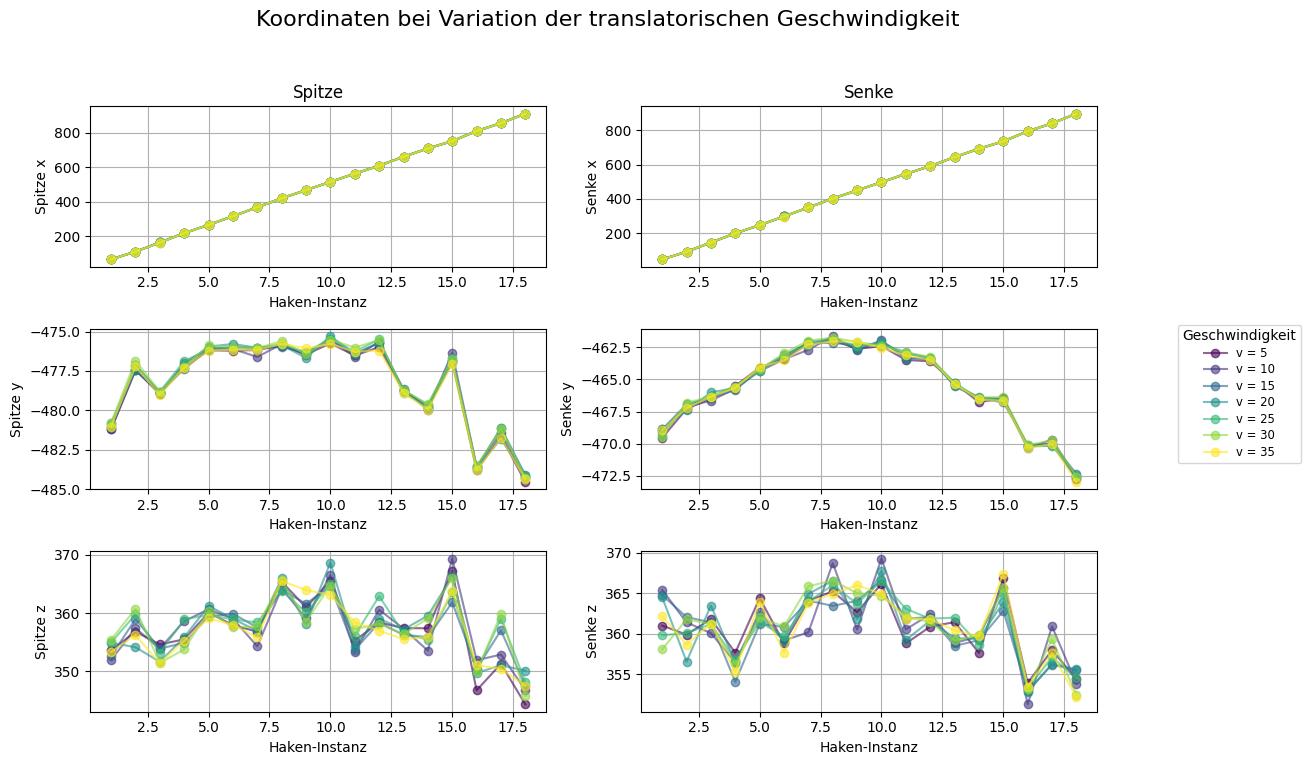

In [69]:
plot_speed_values(dicts_list, [5, 10, 15, 20, 25, 30, 35])

**Mittelwert berechnen**

In [ ]:
mean_xyz_tip_in_workframe, mean_xyz_lowpoint_in_workframe = calculate_mean(dicts_list)
print("Mittlere Abweichung Spitze - ", mean_xyz_tip_in_workframe)
print("Mittlere Abweichung Senke - ", mean_xyz_lowpoint_in_workframe)

Mittlere Abweichung Spitze -  [array([  64.30807114, -491.30596015,  360.05448368]), array([ 106.78281254, -493.78393709,  354.96753878]), array([ 142.26718388, -489.9556    ,  360.77504612]), array([ 183.3844381 , -494.13509007,  353.38948946]), array([ 219.2156383 , -493.00775756,  348.07868899]), array([ 256.52128465, -489.53725295,  357.65392968]), array([ 295.1200049 , -493.35869393,  347.11033601]), array([ 340.54180613, -498.82054588,  353.14816255]), array([ 375.10928385, -497.32036171,  340.67695146]), array([ 397.11332743, -496.45356792,  350.37941082]), array([ 464.31913359, -510.66648703,  343.3113594 ]), array([ 500.55226499, -498.36341128,  345.09397219]), array([ 534.34334962, -500.41887154,  339.22959998]), array([ 574.74776883, -499.02245674,  340.59595429]), array([ 617.92906423, -504.37305513,  346.86194768]), array([ 657.3609587 , -498.02641379,  344.17118482]), array([ 690.39513768, -495.05818524,  339.70466091]), array([ 735.37325153, -497.85138152,  345.20387904]

**Standardabweichung und Verteilung berechnen**

---------------------------------------------------------------------------------------------------------
Daten für Haken  1


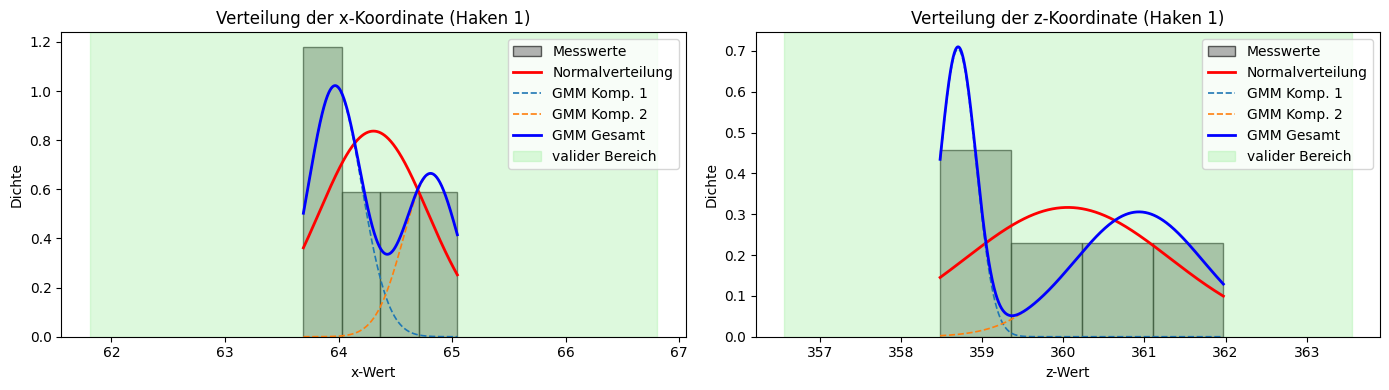

x-Achse: μ-Komponenten = [63.97 64.81], σ-Komponenten = [0.23 0.24], Gewichte = [0.6 0.4]
Zielbereich (angepasst): [61.81, 66.81] → Wahrscheinlichkeit = 100.00 %

z-Achse: μ-Komponenten = [358.7  360.93], σ-Komponenten = [0.22 0.79], Gewichte = [0.39 0.61]
Zielbereich (angepasst): [356.55, 363.55] → Wahrscheinlichkeit = 99.97 %

Gesamte Wahrscheinlichkeit, dass die **ganze Hakenspitze** im Slot liegt (GMM): 99.97 %



KeyError: 'y'

In [ ]:
mu_x_mean = 0
mu_y_mean = 0
mu_z_mean = 0

std_x_mean = 0
std_y_mean = 0
std_z_mean = 0

for hook_num in range(len(dicts_list[0])):
    mu_std_results, probs = plot_prob_and_hist(hook_num+1, dicts_list)
    
    mu_x_mean += mu_std_results['x'][0]
    mu_y_mean += mu_std_results['y'][0]
    mu_z_mean += mu_std_results['z'][0]
    
    std_x_mean += mu_std_results['x'][1]
    std_y_mean += mu_std_results['y'][1]
    std_z_mean += mu_std_results['z'][1]

mu_x_mean /= len(dicts_list[0])
mu_y_mean /= len(dicts_list[0])
mu_z_mean /= len(dicts_list[0])

std_x_mean /= len(dicts_list[0])
std_y_mean /= len(dicts_list[0])
std_z_mean /= len(dicts_list[0])

print("Durchschnittliche Verteilungs-Mittelwerte - XYZ: ", mu_x_mean, mu_y_mean, mu_z_mean)
print("Durchschnittliche Standardabweichungen - XYZ: ", std_x_mean, std_y_mean, std_z_mean)

***
## **Triangulationsmethoden**

In [ ]:
horizontal_0_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/0/global_hook_dict_horizontal.csv'
horizontal_far_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/-20/global_hook_dict_horizontal.csv'
horizontal_near_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/1_Horizontale-Triangulation/20/global_hook_dict_horizontal.csv'

vertical_0_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/2_Vertikale-Triangulation/0/global_hook_dict_vertical.csv'
vertical_far_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/2_Vertikale-Triangulation/-20/global_hook_dict_vertical.csv'
vertical_near_filepath = '/home/mo/Thesis/Evaluation/1_Scan-Prozess/1_Triangulationsmethoden/2_Vertikale-Triangulation/20/global_hook_dict_vertical.csv'

In [ ]:
horizontal_0_dict = load_csv_to_dict(horizontal_0_filepath)
horizontal_far_dict = load_csv_to_dict(horizontal_far_filepath)
horizontal_near_dict = load_csv_to_dict(horizontal_near_filepath)

vertical_0_dict = load_csv_to_dict(vertical_0_filepath)
vertical_far_dict = load_csv_to_dict(vertical_far_filepath)
vertical_near_dict = load_csv_to_dict(vertical_near_filepath)

print("Dicts in Ordnung!") if len(horizontal_0_dict) == len(horizontal_far_dict) == len(horizontal_near_dict) == len(vertical_0_dict) == len(vertical_far_dict) == len(vertical_near_dict) else print("Ungleiche Längen!")

Dicts in Ordnung!


In [ ]:
def extract_xyz_vals(horizontal_dicts_list, vertical_dicts_list):
    """
    - Extrahiert für jeden Haken die XYZ-Werte für Tip und Lowpoint - für beide Triangulationsmethoden
    - Berechnet die kombinierte Triangulation als Mittelwert beider Ergebnisse
    """
    horizontal_vals = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
        }
    vertical_vals = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
        }
    combined_vals = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
        }

    for hook_idx in range(len(horizontal_dicts_list[0])-2):
        hook_key = str(hook_idx + 1)
        for dict_idx in range(len(horizontal_dicts_list)):
            dict = horizontal_dicts_list[dict_idx]
            xyz_tip_in_camframe = dict[hook_key]['xyz_tip_in_camframe']
            xyz_lowpoint_in_camframe = dict[hook_key]['xyz_lowpoint_in_camframe']
            horizontal_vals['x_tip_vals'].append(xyz_tip_in_camframe[0])
            horizontal_vals['y_tip_vals'].append(xyz_tip_in_camframe[1])
            horizontal_vals['z_tip_vals'].append(xyz_tip_in_camframe[2])
            horizontal_vals['x_lowpoint_vals'].append(xyz_lowpoint_in_camframe[0])
            horizontal_vals['y_lowpoint_vals'].append(xyz_lowpoint_in_camframe[1])
            horizontal_vals['z_lowpoint_vals'].append(xyz_lowpoint_in_camframe[2])
            
        for dict_idx in range(len(vertical_dicts_list)):
            dict = vertical_dicts_list[dict_idx]
            xyz_tip_in_camframe = dict[hook_key]['xyz_tip_in_camframe']
            xyz_lowpoint_in_camframe = dict[hook_key]['xyz_lowpoint_in_camframe']
            vertical_vals['x_tip_vals'].append(xyz_tip_in_camframe[0])
            vertical_vals['y_tip_vals'].append(xyz_tip_in_camframe[1])
            vertical_vals['z_tip_vals'].append(xyz_tip_in_camframe[2])
            vertical_vals['x_lowpoint_vals'].append(xyz_lowpoint_in_camframe[0])
            vertical_vals['y_lowpoint_vals'].append(xyz_lowpoint_in_camframe[1])
            vertical_vals['z_lowpoint_vals'].append(xyz_lowpoint_in_camframe[2])

            combined_vals['x_tip_vals'].append((xyz_tip_in_camframe[0] + horizontal_vals['x_tip_vals'][dict_idx])/2)
            combined_vals['y_tip_vals'].append((xyz_tip_in_camframe[1] + horizontal_vals['y_tip_vals'][dict_idx])/2)
            combined_vals['z_tip_vals'].append((xyz_tip_in_camframe[2] + horizontal_vals['z_tip_vals'][dict_idx])/2)
            combined_vals['x_lowpoint_vals'].append((xyz_tip_in_camframe[0] + horizontal_vals['x_lowpoint_vals'][dict_idx])/2)
            combined_vals['y_lowpoint_vals'].append((xyz_tip_in_camframe[1] + horizontal_vals['y_lowpoint_vals'][dict_idx])/2)
            combined_vals['z_lowpoint_vals'].append((xyz_tip_in_camframe[2] + horizontal_vals['z_lowpoint_vals'][dict_idx])/2)
    return horizontal_vals, vertical_vals, combined_vals

In [ ]:
def plot_xyz_values(horizontal_vals_dict, vertical_vals_dict, combined_vals_dict, to_plot='tip'):
    """
    Erstellt einen 3x3 Plot zur Darstellung der XYZ-Koordinaten für Horizontal, Vertikal, Kombiniert
        -> die Koordinaten sind entweder für Spitze (tip) oder Senke (lowpoint) aufgezeichnet -> steht im Plot-Titel
    """
    
    # Farben und zugehörige Labels im rotierenden Muster
    colors = ['black', 'green', 'red']
    labels = ['mittel', 'nah', 'fern']

    # Auswahl der richtigen Keys basierend auf 'to_plot'
    key_suffix = f"_{to_plot}_vals"

    # Dictionaries der drei Kategorien
    all_data = {
        'Horizontal': horizontal_vals_dict,
        'Vertikal': vertical_vals_dict,
        'Kombiniert': combined_vals_dict
    }

    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    fig.suptitle(f"XYZ-Koordinaten für {to_plot.capitalize()}", fontsize=16)

    # Achsen-Labels
    axes_labels = ['X', 'Y', 'Z']

    for row_idx, (category, data_dict) in enumerate(all_data.items()):
        for col_idx, axis in enumerate(['x', 'y', 'z']):
            ax = axes[row_idx, col_idx]
            vals = data_dict[f'{axis}{key_suffix}']

            # Punkte und Linien nach Kategorie zeichnen
            plotted_labels = set()
            grouped_vals = {label: [] for label in labels}
            grouped_indices = {label: [] for label in labels}

            for i, val in enumerate(vals):
                color = colors[i % len(colors)]
                label = labels[i % len(labels)]
                grouped_vals[label].append(val)
                grouped_indices[label].append(i)

                if label not in plotted_labels:
                    ax.plot(i, val, 'o', color=color, label=label)
                    plotted_labels.add(label)
                else:
                    ax.plot(i, val, 'o', color=color)

            # Linien für jede Gruppe zeichnen
            for label, color in zip(labels, colors):
                if grouped_indices[label]:
                    ax.plot(grouped_indices[label], grouped_vals[label], linestyle='-', color=color, alpha=0.7)

            ax.set_title(f"{category} - {axes_labels[col_idx]}")
            ax.set_xlabel('Haken-Instanz')
            ax.set_ylabel(f'{axes_labels[col_idx]}-Wert')
            ax.grid()
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

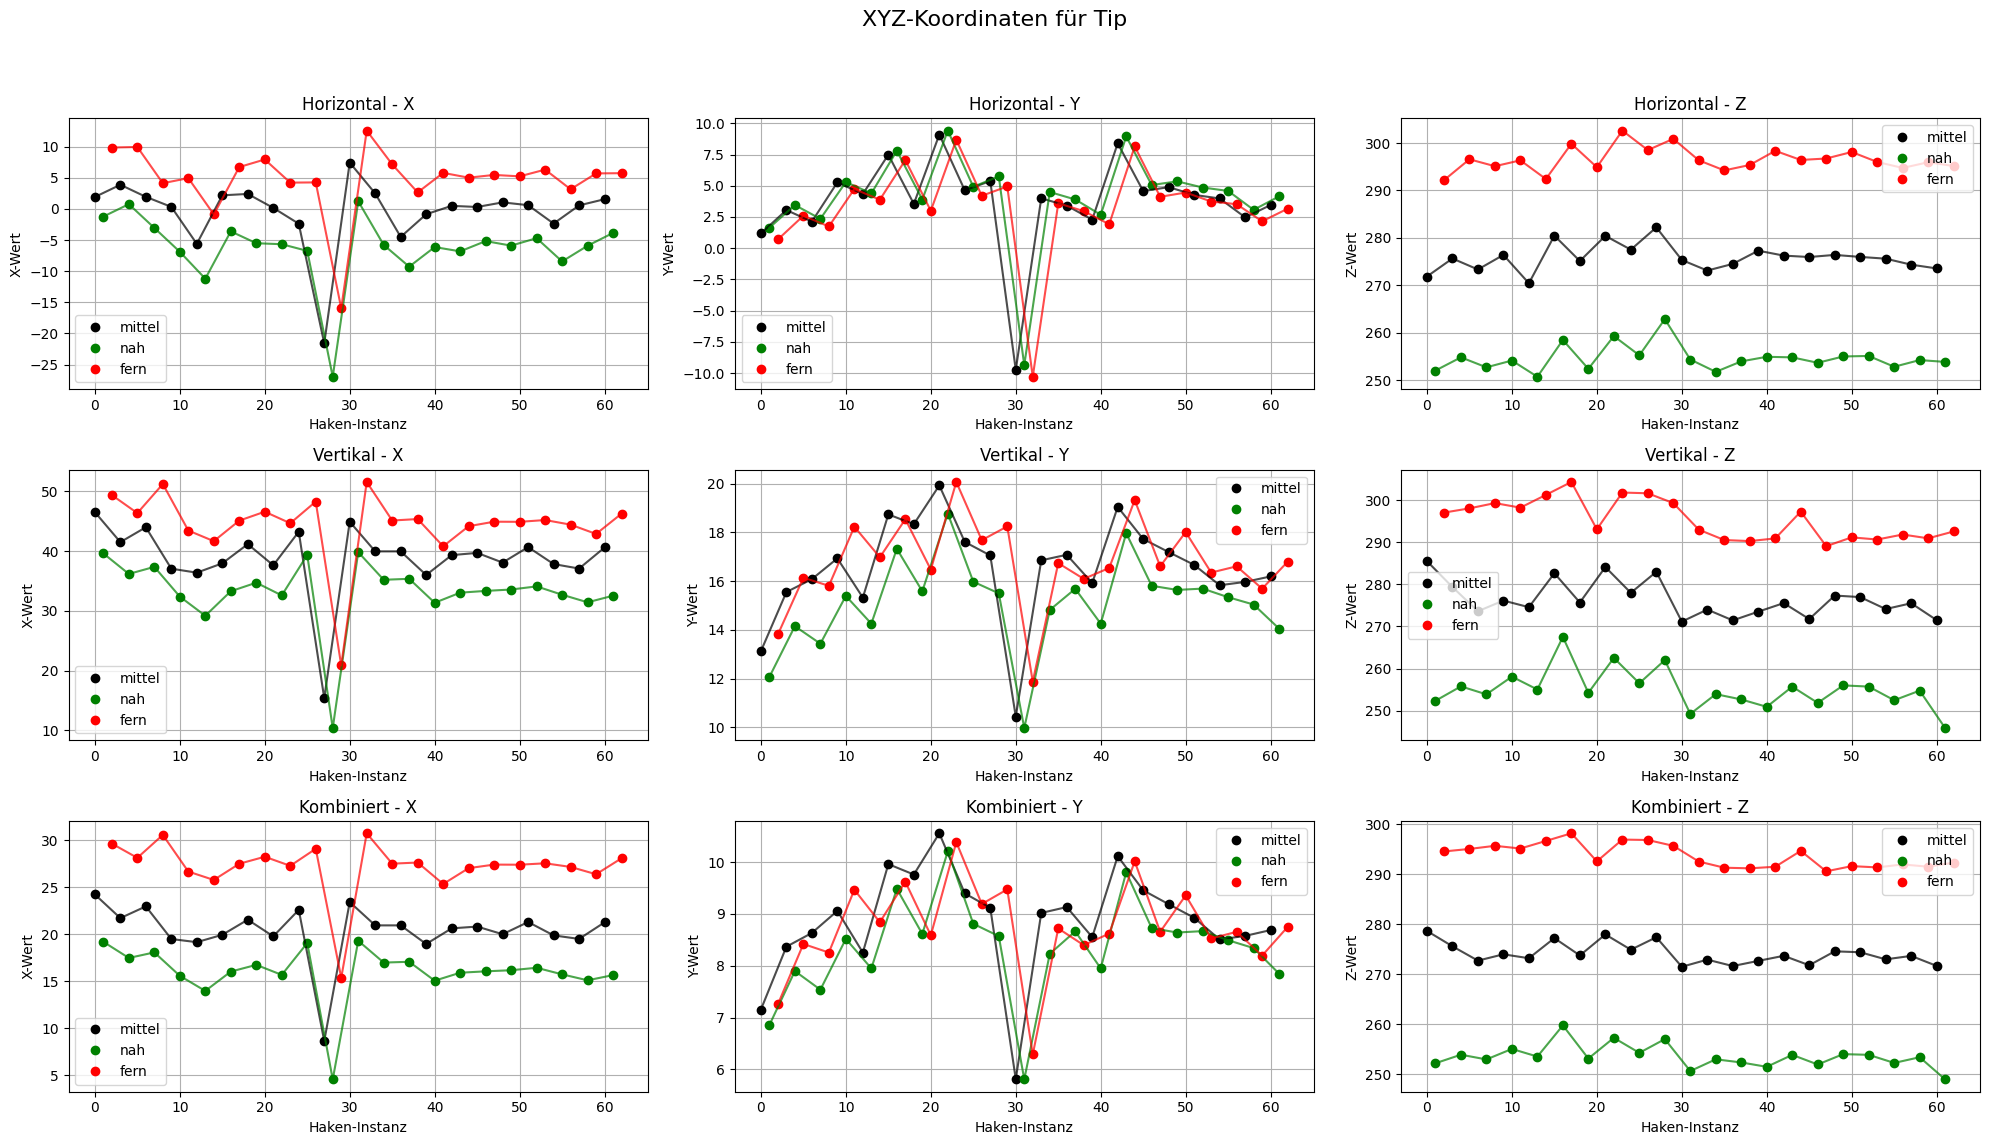

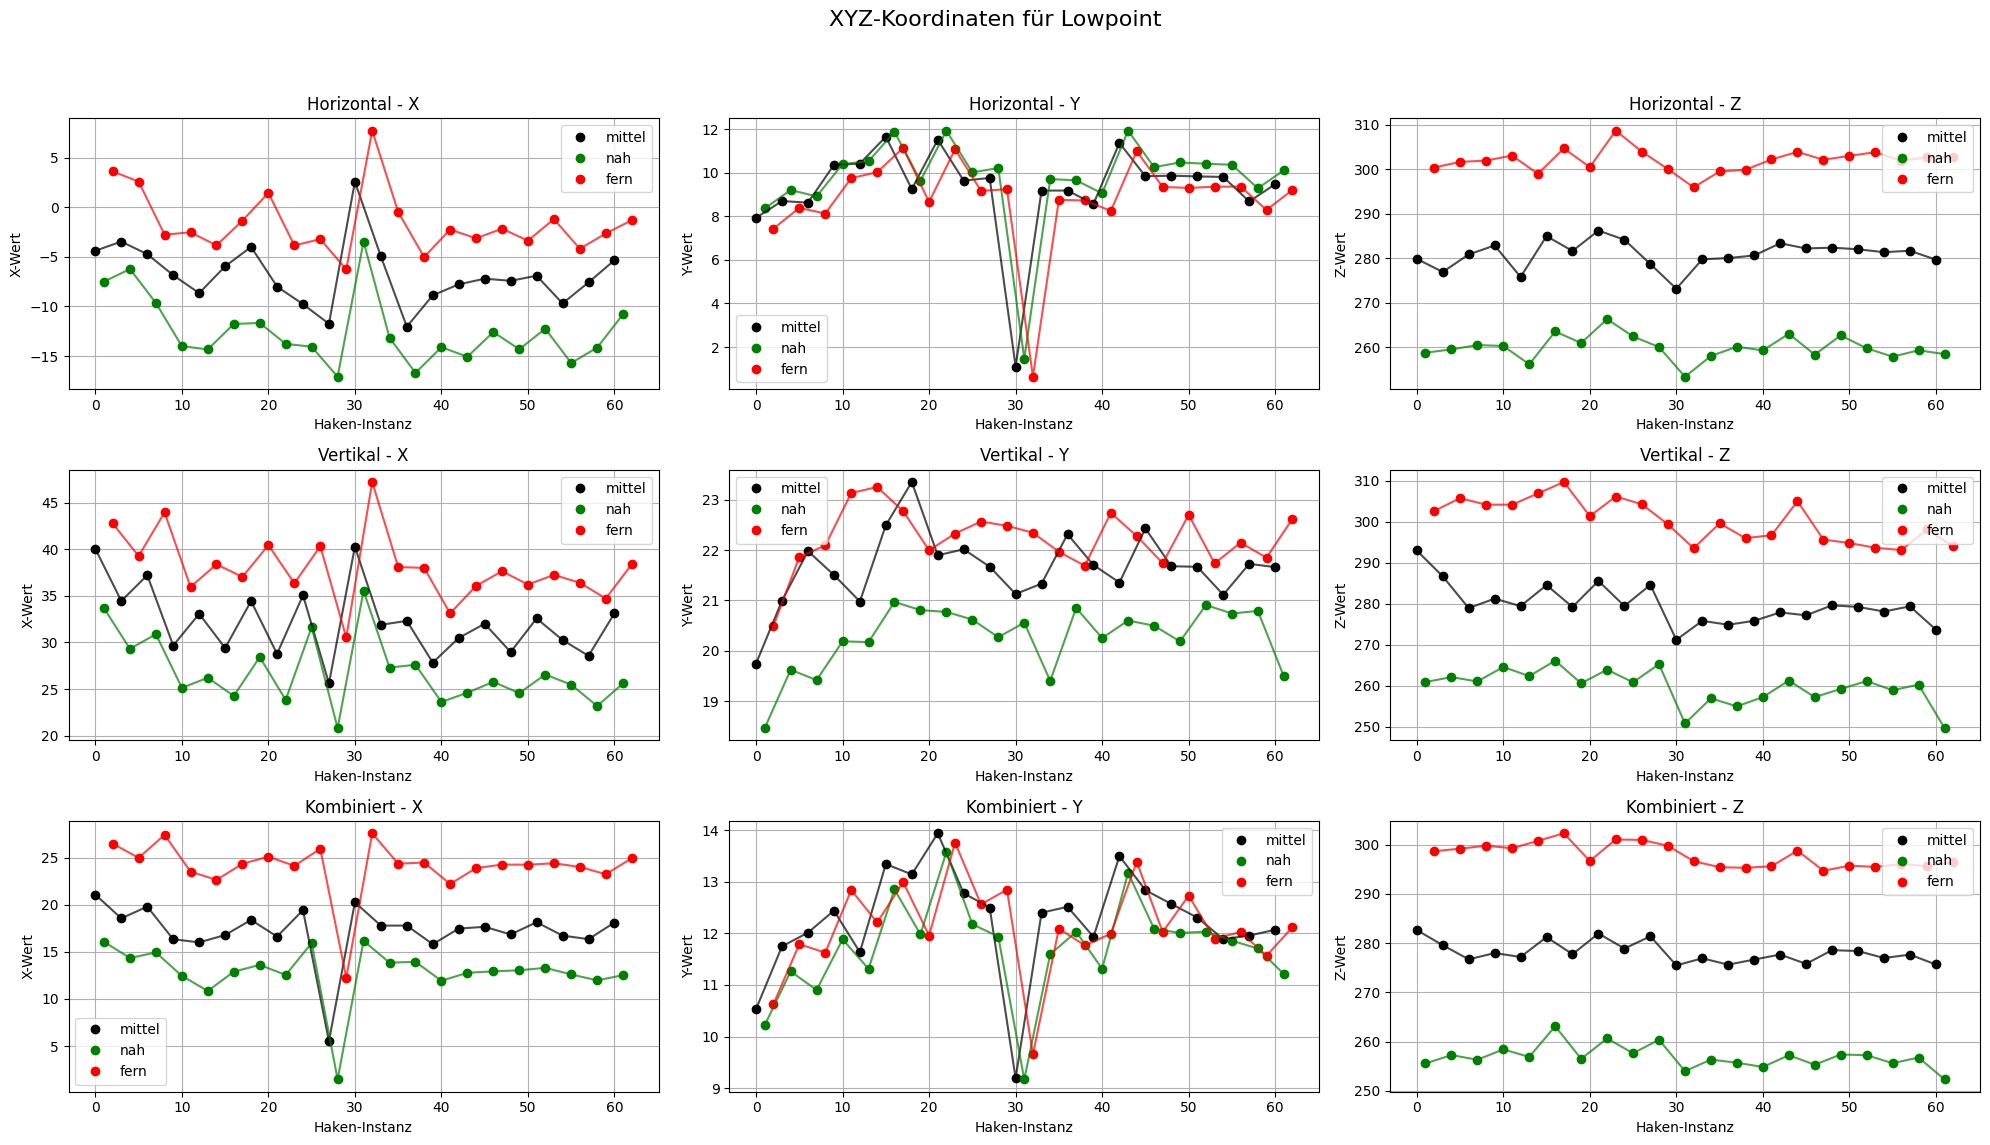

In [ ]:
horizontal_dicts_list = [horizontal_0_dict, horizontal_near_dict, horizontal_far_dict]
vertical_dicts_list = [vertical_0_dict, vertical_near_dict, vertical_far_dict]
horizontal_vals, vertical_vals, combined_vals = extract_xyz_vals(horizontal_dicts_list, vertical_dicts_list)
plot_xyz_values(horizontal_vals, vertical_vals, combined_vals, 'tip')
plot_xyz_values(horizontal_vals, vertical_vals, combined_vals, 'lowpoint')

In [ ]:
def calculate_differences(vals_dict):
    """
    Berechnet die Differenzen zwischen den drei Messreihen für jedes Verfahren
    """
    mean_far_diffs = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
    }
    mean_near_diffs = {
        'x_tip_vals': [],
        'y_tip_vals': [],
        'z_tip_vals': [],
        'x_lowpoint_vals': [],
        'y_lowpoint_vals': [],
        'z_lowpoint_vals': []
    }

    for val_idx in range(0, len(vals_dict['x_tip_vals']) - 2, 3):
        mean_near_diffs['x_tip_vals'].append(vals_dict['x_tip_vals'][val_idx] - vals_dict['x_tip_vals'][val_idx+1])
        mean_far_diffs['x_tip_vals'].append(vals_dict['x_tip_vals'][val_idx] - vals_dict['x_tip_vals'][val_idx+2])
        mean_near_diffs['y_tip_vals'].append(vals_dict['y_tip_vals'][val_idx] - vals_dict['y_tip_vals'][val_idx+1])
        mean_far_diffs['y_tip_vals'].append(vals_dict['y_tip_vals'][val_idx] - vals_dict['y_tip_vals'][val_idx+2])
        mean_near_diffs['z_tip_vals'].append(vals_dict['z_tip_vals'][val_idx] - vals_dict['z_tip_vals'][val_idx+1])
        mean_far_diffs['z_tip_vals'].append(vals_dict['z_tip_vals'][val_idx] - vals_dict['z_tip_vals'][val_idx+2])

        mean_near_diffs['x_lowpoint_vals'].append(vals_dict['x_lowpoint_vals'][val_idx] - vals_dict['x_lowpoint_vals'][val_idx+1])
        mean_far_diffs['x_lowpoint_vals'].append(vals_dict['x_lowpoint_vals'][val_idx] - vals_dict['x_lowpoint_vals'][val_idx+2])
        mean_near_diffs['y_lowpoint_vals'].append(vals_dict['y_lowpoint_vals'][val_idx] - vals_dict['y_lowpoint_vals'][val_idx+1])
        mean_far_diffs['y_lowpoint_vals'].append(vals_dict['y_lowpoint_vals'][val_idx] - vals_dict['y_lowpoint_vals'][val_idx+2])
        mean_near_diffs['z_lowpoint_vals'].append(vals_dict['z_lowpoint_vals'][val_idx] - vals_dict['z_lowpoint_vals'][val_idx+1])
        mean_far_diffs['z_lowpoint_vals'].append(vals_dict['z_lowpoint_vals'][val_idx] - vals_dict['z_lowpoint_vals'][val_idx+2])

    return mean_far_diffs, mean_near_diffs

In [ ]:
horizontal_far_diffs, horizontal_near_diffs = calculate_differences(horizontal_vals)
vertical_far_diffs, vertical_near_diffs = calculate_differences(vertical_vals)
combined_far_diffs, combined_near_diffs = calculate_differences(combined_vals)

In [ ]:
def plot_diffs(horizontal_far_diffs, horizontal_near_diffs,
               vertical_far_diffs, vertical_near_diffs,
               combined_far_diffs, combined_near_diffs,
               to_plot='tip'):
    """
    Plottet einen 3x3 Plot für die Differenz-Werte
        -> entweder für Spitze (tip) oder Senke (lowpoint)
    """
    
    colors = {'nah': 'green', 'fern': 'red'}
    
    key_suffix = f"_{to_plot}_vals"

    # Struktur der Daten
    all_data = {
        'Horizontale Triangulation': {'nah': horizontal_near_diffs, 'fern': horizontal_far_diffs},
        'Vertikale Triangulation': {'nah': vertical_near_diffs, 'fern': vertical_far_diffs},
        'Kombinierte Triangulation': {'nah': combined_near_diffs, 'fern': combined_far_diffs},
    }

    fig, axes = plt.subplots(3, 3, figsize=(20, 12))
    fig.suptitle(f"Differenzen für {to_plot.capitalize()}", fontsize=16)

    axes_labels = ['X', 'Y', 'Z']

    for row_idx, (category, sources) in enumerate(all_data.items()):
        for col_idx, axis in enumerate(['x', 'y', 'z']):
            ax = axes[row_idx, col_idx]
            for label, data_dict in sources.items():
                vals = data_dict[f'{axis}{key_suffix}']
                if vals:
                    ax.plot(range(len(vals)), vals, 'o-', color=colors[label], label=label)

            # Zusätzliche Linien für z-Achsen
            if axis == 'z':
                for y in [-20, 0, 20]:
                    ax.axhline(y=y, linestyle='--', color='magenta', linewidth=2, label=f'soll {y}')

            ax.set_title(f"{category} - {axes_labels[col_idx]}")
            ax.set_xlabel('Haken-Instanz')
            ax.set_ylabel(f'Diff {axes_labels[col_idx]}')
            ax.grid()
            ax.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

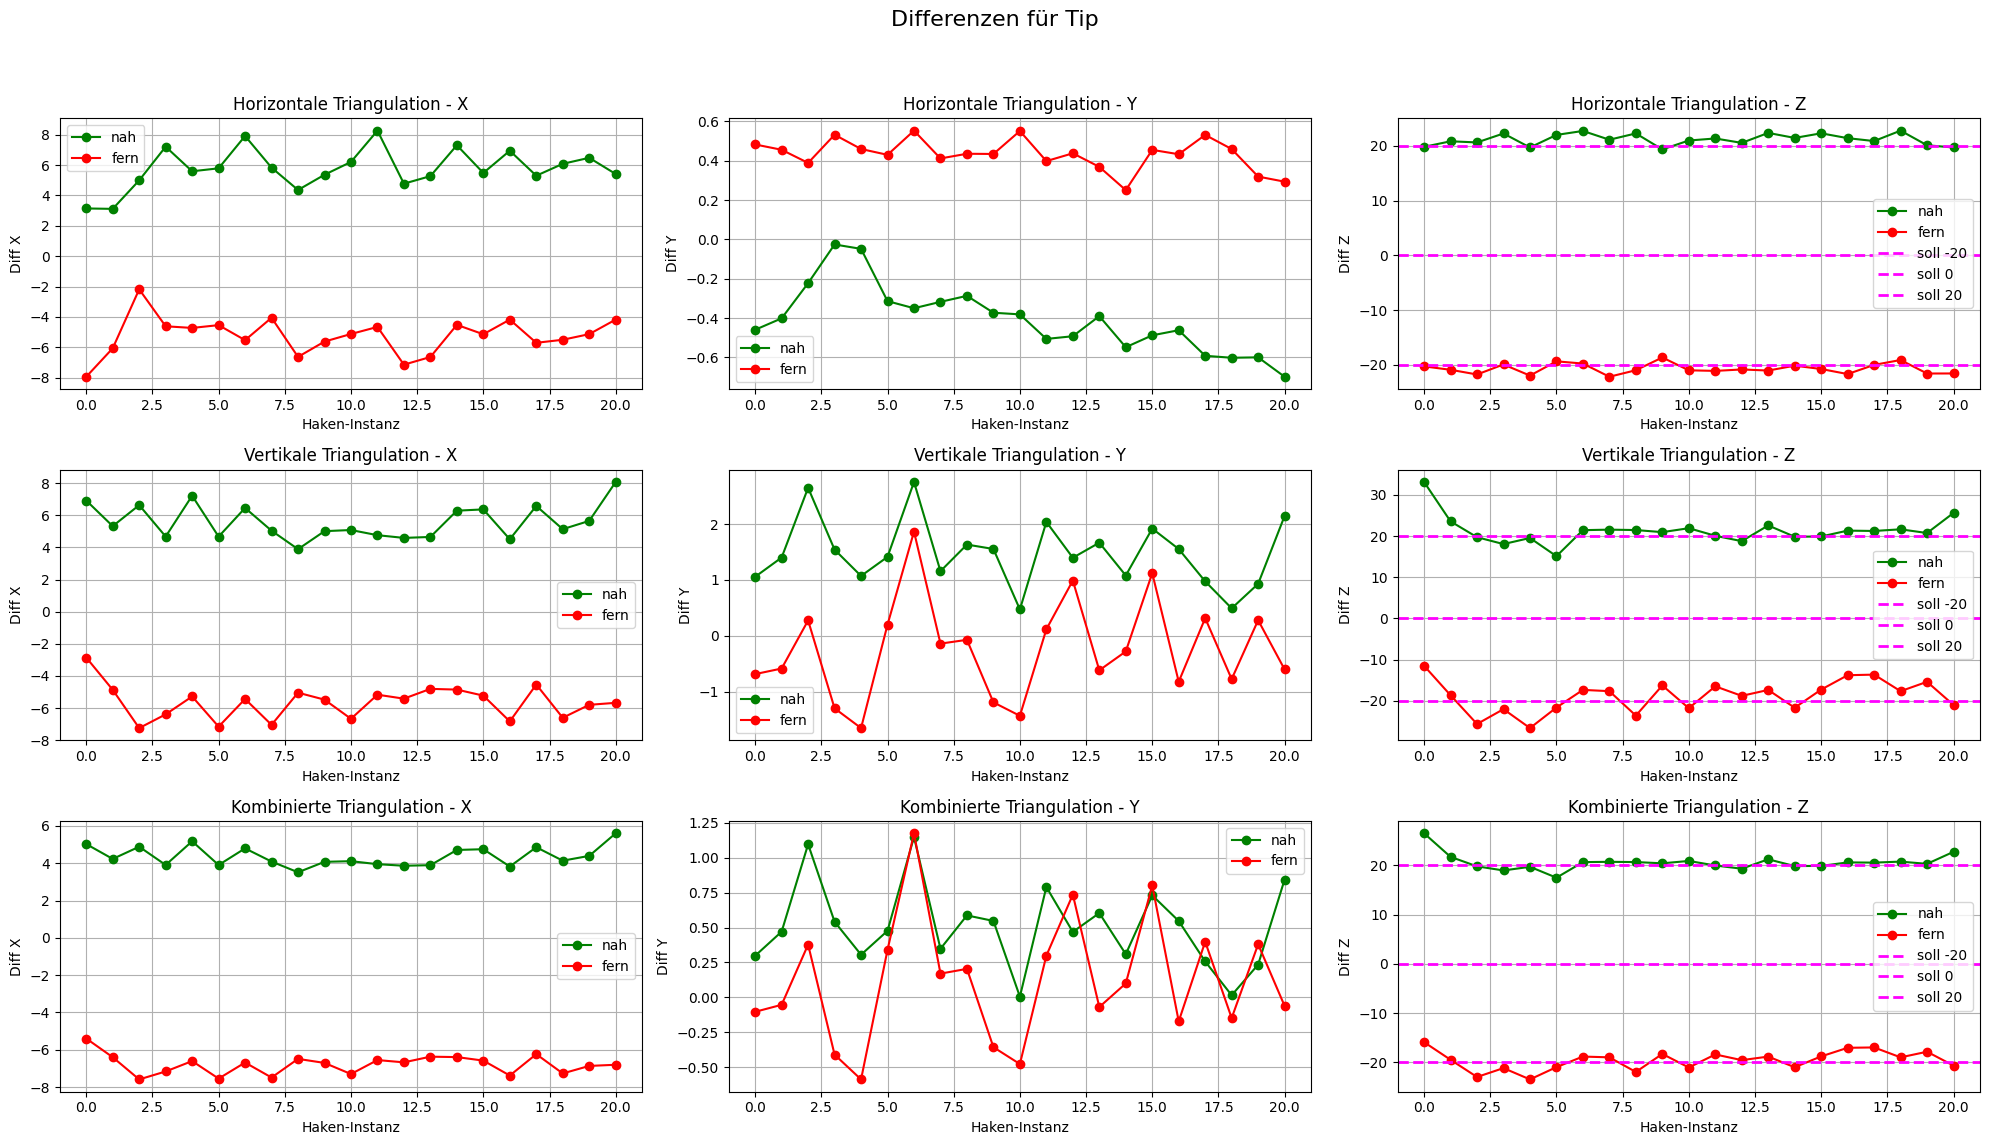

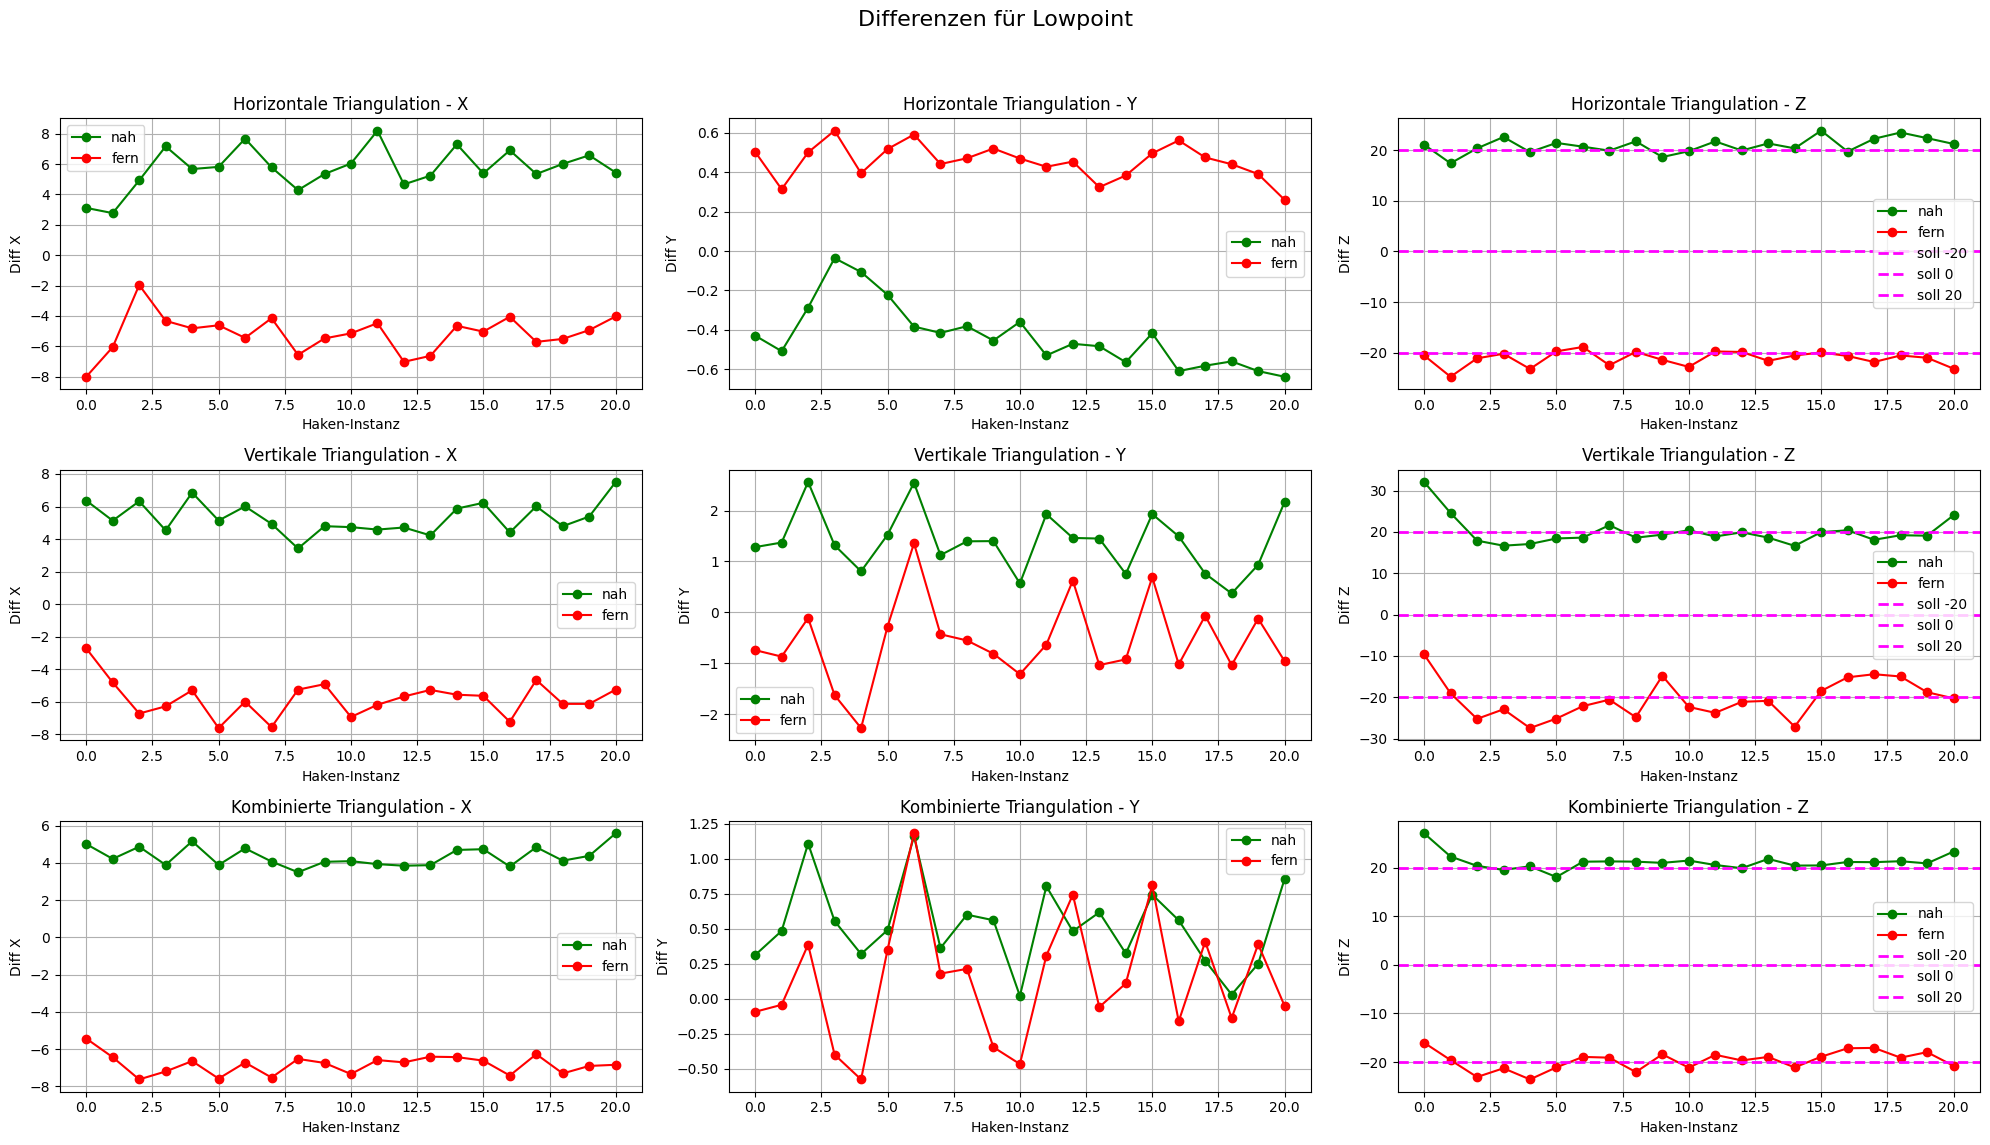

In [ ]:
plot_diffs(
    horizontal_far_diffs, horizontal_near_diffs,
    vertical_far_diffs, vertical_near_diffs,
    combined_far_diffs, combined_near_diffs,
    'tip'
)

plot_diffs(
    horizontal_far_diffs, horizontal_near_diffs,
    vertical_far_diffs, vertical_near_diffs,
    combined_far_diffs, combined_near_diffs,
    'lowpoint'
)